# 📊 Regressão Linear Simples — Precificação de Risco em Empréstimos
## Risk-Based Pricing com Lending Club Loan Data

**Autor:** Caio Thomas Silva Bandeira  
**Disciplina:** Ciência de Dados para Engenheiros — Deep Learning  
**Instituição:** CEUB — Centro Universitário de Brasília  
**Professor:** George Kuroki Jr.

---

### Objetivo do Projeto

Construir e avaliar **3 modelos de Regressão Linear Simples**, cada um usando uma variável independente diferente para prever a **taxa de juros (`int_rate`)** de empréstimos. Cada modelo é implementado via:

1. **statsmodels** — Sumário estatístico completo (OLS)
2. **TensorFlow/Keras** — Rede neural simples (single-neuron)

O foco é o **rigor estatístico** (verificação de premissas) e a **clareza didática**.

---
## 1 · Configuração do Ambiente e Importação de Bibliotecas

Importamos todas as bibliotecas necessárias para o projeto. Cada uma tem um papel específico:

| Biblioteca | Papel |
|---|---|
| `pandas` / `numpy` | Manipulação e estrutura de dados |
| `matplotlib` / `seaborn` | Visualizações e gráficos estatísticos |
| `statsmodels` | Regressão OLS com sumário estatístico detalhado (p-values, R², F-stat) |
| `tensorflow/keras` | Rede neural simples (1 neurônio linear) |
| `scipy` | Testes estatísticos (Shapiro-Wilk) |
| `kagglehub` | Download automático do dataset do Kaggle |

In [1]:
# =============================================================================
# 1. IMPORTAÇÃO DE BIBLIOTECAS
# =============================================================================
# Cada importação é agrupada por função para facilitar a leitura e manutenção.

# --- Supressão de warnings ---
# Fazemos isso logo no início para que o notebook não fique poluído com avisos
# do TensorFlow e de depreciações que não afetam nosso resultado.
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suprime logs internos do TensorFlow

# --- Manipulação de Dados ---
import pandas as pd   # Estrutura de DataFrames (tabelas)
import numpy as np    # Operações numéricas vetorizadas

# --- Visualização ---
import matplotlib.pyplot as plt  # Gráficos estáticos (base)
import seaborn as sns            # Gráficos estatísticos de alto nível

# --- Modelagem Estatística (statsmodels) ---
# O statsmodels nos dá o "sumário completo" da regressão: p-values, R²,
# intervalos de confiança, F-statistic — tudo que precisamos para rigor estatístico.
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot          # Q-Q Plot para normalidade dos resíduos
from statsmodels.stats.stattools import durbin_watson      # Teste de independência dos resíduos
from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF (multicolinearidade)

# --- Deep Learning (TensorFlow / Keras) ---
# Usaremos uma rede neural com UM ÚNICO neurônio linear para demonstrar que
# é algebricamente idêntica à regressão linear: ŷ = Wx + b ≡ ŷ = β₁x + β₀
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# --- Testes Estatísticos (SciPy) ---
from scipy.stats import shapiro  # Teste de Shapiro-Wilk para normalidade dos resíduos

# --- Download do Dataset ---
import kagglehub  # Download automático de datasets do Kaggle

# =============================================================================
# FUNÇÕES AUXILIARES — substituem funcionalidades que eram do sklearn
# =============================================================================

def train_test_split_manual(X, y, test_size=0.2, random_state=42):
    """
    Divisão manual treino/teste usando numpy (substitui sklearn.model_selection.train_test_split).
    
    Parâmetros:
        X: array de features (n, p)
        y: array de target (n,)
        test_size: proporção do teste (0.0 a 1.0)
        random_state: seed para reprodutibilidade
    
    Retorna:
        X_train, X_test, y_train, y_test
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    indices = rng.permutation(n)
    split_idx = int(n * (1 - test_size))
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def r2_score_manual(y_true, y_pred):
    """
    R² (Coeficiente de Determinação) — proporção da variância explicada.
    R² = 1 - SS_res / SS_tot
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def rmse_manual(y_true, y_pred):
    """RMSE — Raiz do Erro Quadrático Médio."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae_manual(y_true, y_pred):
    """MAE — Erro Médio Absoluto."""
    return np.mean(np.abs(y_true - y_pred))

def standard_scale(X_train, X_test=None):
    """
    Padronização z-score manual (substitui sklearn.preprocessing.StandardScaler).
    z = (x - μ) / σ
    
    Retorna:
        X_train_scaled, X_test_scaled (se X_test fornecido), mean, std
    """
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train_scaled = (X_train - mean) / std
    if X_test is not None:
        X_test_scaled = (X_test - mean) / std
        return X_train_scaled, X_test_scaled, mean, std
    return X_train_scaled, mean, std

# --- Configurações Globais de Visualização ---
sns.set_style('whitegrid')                           # Estilo limpo com grade
plt.rcParams['figure.figsize'] = (12, 6)             # Tamanho padrão dos gráficos
plt.rcParams['font.size'] = 12                       # Tamanho de fonte legível
plt.rcParams['axes.titlesize'] = 14                  # Títulos de eixo maiores

# --- Reprodutibilidade ---
# Fixamos a seed em TODOS os geradores de números aleatórios para garantir
# que qualquer pessoa que rode este notebook obtenha exatamente os mesmos resultados.
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("✅ Todas as bibliotecas foram importadas com sucesso!")
print(f"   Pandas:       {pd.__version__}")
print(f"   NumPy:        {np.__version__}")
print(f"   Matplotlib:   {plt.matplotlib.__version__}")
print(f"   Seaborn:      {sns.__version__}")
print(f"   Statsmodels:  {sm.__version__}")
print(f"   TensorFlow:   {tf.__version__}")

✅ Todas as bibliotecas foram importadas com sucesso!
   Pandas:       3.0.1
   NumPy:        2.4.2
   Matplotlib:   3.10.8
   Seaborn:      0.13.2
   Statsmodels:  0.14.6
   TensorFlow:   2.20.0


---
## 2 · Download e Carregamento do Dataset (Lending Club via KaggleHub)

O **Lending Club Loan Data** é um dos maiores datasets públicos de crédito, contendo informações de ~2,2 milhões de empréstimos concedidos entre 2007 e 2018.

Utilizamos a biblioteca `kagglehub` para download automático. Na primeira execução, será necessário autenticar com sua chave de API do Kaggle.

> **Nota:** O dataset original possui mais de 150 colunas. Carregaremos todas inicialmente e depois selecionaremos apenas as relevantes.

In [6]:
# =============================================================================
# 2. DOWNLOAD E CARREGAMENTO DO DATASET
# =============================================================================
# O kagglehub baixa o dataset e retorna o caminho local onde foi salvo.
# Na primeira execução, pode ser necessário configurar a chave de API do Kaggle.
# Instruções: https://www.kaggle.com/docs/api

import glob
import gc
import time

print("⏳ Baixando o dataset do Kaggle (pode demorar na primeira vez)...")
path = kagglehub.dataset_download('wordsforthewise/lending-club')
print(f"✅ Dataset baixado em: {path}")

# --- Localizar o arquivo CSV dentro da pasta baixada ---
# O kagglehub pode baixar múltiplos arquivos; precisamos do principal.
csv_files = glob.glob(os.path.join(path, '**', '*.csv'), recursive=True)
print(f"\n📂 Arquivos CSV encontrados:")
for f in csv_files:
    print(f"   → {os.path.basename(f)}")

# --- Selecionar o CSV principal ---
# O dataset contém duplicatas (lowercase/uppercase). Priorizamos o "accepted" com Q4 maiúsculo.
csv_path = [f for f in csv_files if 'accepted' in os.path.basename(f).lower()]
# Se houver múltiplos, preferimos o com "Q4" (maiúsculo) que costuma ser o canônico
if len(csv_path) > 1:
    csv_path_Q4 = [f for f in csv_path if 'Q4' in os.path.basename(f)]
    csv_path = csv_path_Q4[0] if csv_path_Q4 else csv_path[0]
else:
    csv_path = csv_path[0] if csv_path else csv_files[0]

print(f"\n⏳ Carregando: {os.path.basename(csv_path)} ...")

# --- Carregar com retry (PermissionError pode ocorrer logo após extração) ---
# O kagglehub extrai arquivos grandes em background; o CSV pode estar temporariamente
# bloqueado pelo sistema operacional. Aguardamos e tentamos novamente.
for tentativa in range(3):
    try:
        gc.collect()  # Libera referências de memória pendentes
        df_raw = pd.read_csv(csv_path, low_memory=False)
        break
    except PermissionError:
        if tentativa < 2:
            wait = (tentativa + 1) * 5
            print(f"   ⚠️  Arquivo temporariamente bloqueado. Aguardando {wait}s... (tentativa {tentativa + 1}/3)")
            time.sleep(wait)
        else:
            # Última tentativa: tentar o outro arquivo (lowercase)
            csv_alt = [f for f in csv_files if 'accepted' in os.path.basename(f).lower() and f != csv_path]
            if csv_alt:
                print(f"   🔄 Tentando arquivo alternativo: {os.path.basename(csv_alt[0])}")
                df_raw = pd.read_csv(csv_alt[0], low_memory=False)
            else:
                raise

print(f"✅ Dataset carregado com sucesso!")
print(f"   Shape original: {df_raw.shape[0]:,} linhas × {df_raw.shape[1]} colunas")

# --- Visualizar as primeiras linhas ---
df_raw.head(3)

⏳ Baixando o dataset do Kaggle (pode demorar na primeira vez)...
✅ Dataset baixado em: C:\Users\caio\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3

📂 Arquivos CSV encontrados:
   → accepted_2007_to_2018q4.csv
   → rejected_2007_to_2018q4.csv
   → accepted_2007_to_2018Q4.csv
   → rejected_2007_to_2018Q4.csv

⏳ Carregando: accepted_2007_to_2018Q4.csv ...
✅ Dataset baixado em: C:\Users\caio\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3

📂 Arquivos CSV encontrados:
   → accepted_2007_to_2018q4.csv
   → rejected_2007_to_2018q4.csv
   → accepted_2007_to_2018Q4.csv
   → rejected_2007_to_2018Q4.csv

⏳ Carregando: accepted_2007_to_2018Q4.csv ...
✅ Dataset carregado com sucesso!
   Shape original: 2,260,701 linhas × 151 colunas
✅ Dataset carregado com sucesso!
   Shape original: 2,260,701 linhas × 151 colunas


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  

[3 rows x 151 columns]

---
## 3 · Amostragem Estratificada (300.000 registros por `grade`)

Com ~2,2 milhões de linhas, processar o dataset completo seria demorado e desnecessário para o escopo deste projeto. Vamos extrair uma **amostra de 300.000 registros**.

**Por que estratificada?** A coluna `grade` (A, B, C, D, E, F, G) representa a classificação de risco atribuída pelo Lending Club. Se fizéssemos amostragem aleatória simples, poderíamos sub-representar grades raras (F, G). A amostragem estratificada garante que **a proporção de cada grade no sample seja igual à do dataset original**.

In [7]:
# =============================================================================
# 3. AMOSTRAGEM ESTRATIFICADA — 300.000 REGISTROS
# =============================================================================
# Precisamos que a coluna 'grade' exista e não tenha NaN para estratificar.
# Primeiro verificamos; depois amostramos proporcionalmente.

SAMPLE_SIZE = 300_000

# Remover linhas onde 'grade' é NaN (são poucas, se existirem)
df_raw = df_raw.dropna(subset=['grade'])

# --- Verificar a distribuição original de grade ---
print("📊 Distribuição original de 'grade':")
grade_dist_original = df_raw['grade'].value_counts(normalize=True).sort_index()
print(grade_dist_original.apply(lambda x: f"{x:.2%}"))
print(f"\n   Total de registros: {len(df_raw):,}")

# --- Calcular a fração necessária para obter ~300k registros ---
frac = SAMPLE_SIZE / len(df_raw)

# --- Amostragem estratificada ---
# Usamos uma abordagem direta: para cada grade, amostramos proporcionalmente.
amostras = []
for grade_val, grupo in df_raw.groupby('grade'):
    n_amostrar = int(round(len(grupo) * frac))
    amostras.append(grupo.sample(n=n_amostrar, random_state=RANDOM_STATE))

df_sample = pd.concat(amostras, ignore_index=True)

print(f"\n✅ Amostra criada: {len(df_sample):,} registros")

# --- Comparar proporções: original vs amostra ---
comparison = pd.DataFrame({
    'Original (%)': grade_dist_original * 100,
    'Amostra (%)':  df_sample['grade'].value_counts(normalize=True).sort_index() * 100
}).round(2)
comparison['Diferença (pp)'] = (comparison['Amostra (%)'] - comparison['Original (%)']).round(2)
print("\n📋 Comparação de proporções (Original vs Amostra):")
comparison

📊 Distribuição original de 'grade':
grade
A    19.15%
B    29.35%
C    28.75%
D    14.35%
E     6.00%
F     1.85%
G     0.54%
Name: proportion, dtype: str

   Total de registros: 2,260,668

✅ Amostra criada: 300,000 registros

📋 Comparação de proporções (Original vs Amostra):

✅ Amostra criada: 300,000 registros

📋 Comparação de proporções (Original vs Amostra):


Original (%)  Amostra (%)  Diferença (pp)
grade                                           
A             19.15        19.15             0.0
B             29.35        29.35             0.0
C             28.75        28.75             0.0
D             14.35        14.35             0.0
E              6.00         6.00             0.0
F              1.85         1.85             0.0
G              0.54         0.54             0.0

---
## 4 · Seleção de Variáveis e Engenharia de Features

Selecionamos apenas as colunas relevantes e criamos a feature `fico_score`:

| Variável | Descrição |
|---|---|
| `int_rate` | **Variável-alvo** — Taxa de juros (%) |
| `annual_inc` | Renda anual declarada (USD) |
| `dti` | Debt-to-Income ratio (%) — razão dívida/renda |
| `fico_range_low` / `fico_range_high` | Faixa do score FICO → criamos `fico_score` = média |
| `grade` | Classificação de risco (usada na amostragem; será dropada) |

> **Sobre o `fico_score`:** O FICO score é fornecido em faixa (ex: 670–674). Calcular a **média aritmética** das extremidades é a aproximação padrão utilizada na literatura.

In [8]:
# =============================================================================
# 4. SELEÇÃO DE VARIÁVEIS E ENGENHARIA DE FEATURES
# =============================================================================

# --- Selecionar apenas as colunas que precisamos ---
# Isso reduz drasticamente o uso de memória e simplifica o trabalho.
colunas_relevantes = ['int_rate', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'grade']
df = df_sample[colunas_relevantes].copy()

# --- Garantir que int_rate é numérico ---
# Em algumas versões do dataset, int_rate vem como string com "%" (ex: "13.56%").
# Precisamos remover o símbolo e converter para float.
if df['int_rate'].dtype == 'object':
    df['int_rate'] = df['int_rate'].str.replace('%', '', regex=False).astype(float)
    print("⚠️  int_rate estava como texto — convertido para float (removido '%').")
else:
    print("✅ int_rate já está em formato numérico.")

# --- Criar a feature fico_score ---
# O FICO score é fornecido em faixa (ex: low=670, high=674).
# A média aritmética é a aproximação padrão: fico_score = (low + high) / 2
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) / 2

# --- Remover colunas auxiliares que não serão mais usadas ---
df = df.drop(columns=['fico_range_low', 'fico_range_high', 'grade'])

print(f"\n✅ DataFrame final: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
print(f"   Colunas: {list(df.columns)}")
df.head()

✅ int_rate já está em formato numérico.

✅ DataFrame final: 300,000 linhas × 4 colunas
   Colunas: ['int_rate', 'annual_inc', 'dti', 'fico_score']


int_rate  annual_inc    dti  fico_score
0      6.67     90000.0  13.68       692.0
1      7.26     48000.0   7.25       697.0
2      8.49     80000.0   7.44       737.0
3      7.90     55000.0  10.47       732.0
4      8.81     55000.0  24.33       727.0

---
## 5 · Tratamento de Valores Ausentes

Antes de qualquer análise, precisamos verificar se há dados faltantes. Valores `NaN` podem:

- **Enviesar os coeficientes** da regressão (se não forem aleatórios).
- **Causar erros** em funções que não aceitam NaN (ex: `shapiro()`, `OLS`).

**Estratégia adotada:** Primeiro, **analisamos o padrão de ausência** para entender se os dados faltantes carregam informação útil. Só removemos NaN das colunas estritamente necessárias para as regressões (`int_rate`, `annual_inc`, `dti`, `fico_score`), pois o OLS exige dados completos. Para todas as demais colunas, os NaN são **preservados** e analisados.

In [9]:
# =============================================================================
# 5. TRATAMENTO DE VALORES AUSENTES
# =============================================================================

# --- Diagnóstico: quantos NaN existem em cada coluna? ---
missing = pd.DataFrame({
    'Qtd. Ausentes': df.isnull().sum(),
    '% Ausentes': (df.isnull().mean() * 100).round(2)
})
print("📋 Valores ausentes por coluna:")
print(missing)
print(f"\n   Shape ANTES do tratamento: {df.shape}")

# --- Análise do padrão de ausência ---
# Verificar se os NaN estão concentrados nas mesmas linhas ou distribuídos
nan_por_linha = df.isnull().sum(axis=1)
print(f"\n📊 Distribuição de NaN por linha:")
print(f"   Linhas sem nenhum NaN:  {(nan_por_linha == 0).sum():,}")
print(f"   Linhas com 1+ NaN:     {(nan_por_linha > 0).sum():,}")
print(f"   Linhas com todos NaN:  {(nan_por_linha == df.shape[1]).sum():,}")

# --- Verificar se os NaN em cada coluna revelam algum padrão ---
# Por exemplo: será que linhas com NaN em 'dti' possuem int_rate diferente?
colunas_regressao = ['int_rate', 'annual_inc', 'dti', 'fico_score']
for col in colunas_regressao:
    n_nan = df[col].isnull().sum()
    if n_nan > 0:
        media_com = df.loc[df[col].notna(), 'int_rate'].mean() if col != 'int_rate' else None
        media_sem = df.loc[df[col].isna(), 'int_rate'].mean() if col != 'int_rate' and df.loc[df[col].isna(), 'int_rate'].notna().any() else None
        print(f"\n   🔍 {col}: {n_nan:,} NaN ({n_nan/len(df)*100:.2f}%)")
        if media_com is not None and media_sem is not None:
            print(f"      int_rate média (com {col}): {media_com:.2f}%")
            print(f"      int_rate média (sem {col}): {media_sem:.2f}%")
            diff = abs(media_com - media_sem)
            print(f"      Diferença: {diff:.2f} pp {'⚠️ significativa' if diff > 1 else '✅ pequena'}")

# --- Remover NaN SOMENTE nas colunas necessárias para a regressão ---
# O OLS exige dados completos nas variáveis X e y. Não podemos regredir com NaN.
# Justificativa: removemos APENAS onde os cálculos exigem.
df = df.dropna(subset=colunas_regressao)

print(f"\n   Shape DEPOIS da remoção (apenas colunas de regressão): {df.shape}")

# --- Confirmar que as colunas de regressão não têm NaN ---
assert df[colunas_regressao].isnull().sum().sum() == 0, "Ainda existem NaN nas colunas de regressão!"
print("\n✅ Nenhum valor ausente nas colunas de regressão.")

📋 Valores ausentes por coluna:
            Qtd. Ausentes  % Ausentes
int_rate                0        0.00
annual_inc              0        0.00
dti                   205        0.07
fico_score              0        0.00

   Shape ANTES do tratamento: (300000, 4)

📊 Distribuição de NaN por linha:
   Linhas sem nenhum NaN:  299,795
   Linhas com 1+ NaN:     205
   Linhas com todos NaN:  0

   🔍 dti: 205 NaN (0.07%)
      int_rate média (com dti): 13.09%
      int_rate média (sem dti): 13.87%
      Diferença: 0.78 pp ✅ pequena

   Shape DEPOIS da remoção (apenas colunas de regressão): (299795, 4)

✅ Nenhum valor ausente nas colunas de regressão.


---
## 6 · Análise Exploratória (EDA) — Estatísticas Descritivas

Antes de modelar, precisamos **entender os dados**. As estatísticas descritivas nos revelam:

- **Tendência central** (média, mediana) — onde se concentram os valores.
- **Dispersão** (desvio-padrão, min/max) — quão espalhados estão.
- **Assimetria** — variáveis como `annual_inc` tendem a ter cauda longa à direita (poucos ganham muito).

Esse entendimento guia decisões posteriores (ex: tratamento de outliers).

In [10]:
# =============================================================================
# 6. ANÁLISE EXPLORATÓRIA — ESTATÍSTICAS DESCRITIVAS
# =============================================================================

# --- Estatísticas descritivas de todas as variáveis numéricas ---
# O .describe() nos dá count, mean, std, min, 25%, 50% (mediana), 75%, max.
print("📊 Estatísticas Descritivas:")
df.describe().round(2)

📊 Estatísticas Descritivas:


int_rate  annual_inc        dti  fico_score
count  299795.00   299795.00  299795.00   299795.00
mean       13.09    77978.81      18.83      700.57
std         4.83    76468.21      14.08       33.02
min         5.31        0.00       0.00      632.00
25%         9.49    46000.00      11.91      677.00
50%        12.62    65000.00      17.85      692.00
75%        15.99    93000.00      24.51      717.00
max        30.99  9522972.00     999.00      847.50

In [11]:
# --- Tipos de dados e informações gerais ---
print("📋 Informações do DataFrame:")
df.info()

📋 Informações do DataFrame:
<class 'pandas.DataFrame'>
Index: 299795 entries, 0 to 299999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   int_rate    299795 non-null  float64
 1   annual_inc  299795 non-null  float64
 2   dti         299795 non-null  float64
 3   fico_score  299795 non-null  float64
dtypes: float64(4)
memory usage: 11.4 MB


---
## 7 · EDA — Distribuição da Variável-Alvo (`int_rate`)

Visualizamos a distribuição da variável que queremos prever. 

> **Importante:** A **normalidade da variável-alvo NÃO é uma premissa da regressão linear**. O que precisa ser normal são os **resíduos** (erros). Porém, entender a distribuição de `int_rate` nos ajuda a compreender o fenômeno e antecipar problemas.

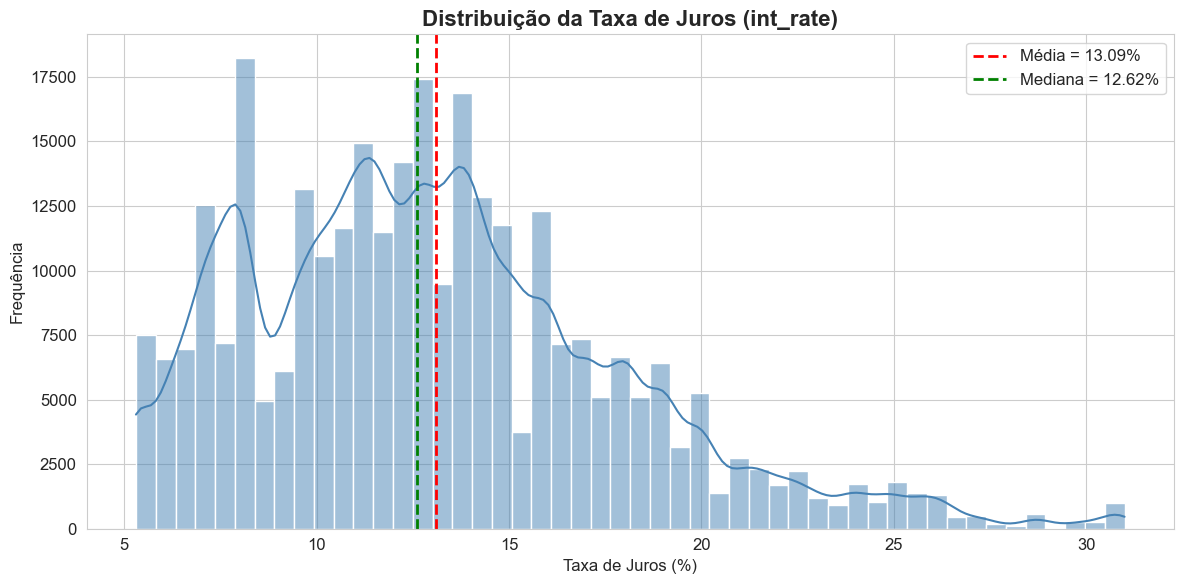

📈 Assimetria (Skewness): 0.768
   → Assimétrica à direita (positiva)
📈 Curtose (Kurtosis):    0.592
   → Leptocúrtica (caudas pesadas)


In [12]:
# =============================================================================
# 7. DISTRIBUIÇÃO DA VARIÁVEL-ALVO (int_rate)
# =============================================================================

from scipy.stats import skew, kurtosis

fig, ax = plt.subplots(figsize=(12, 6))

# Histograma com curva KDE (Kernel Density Estimation)
sns.histplot(df['int_rate'], kde=True, bins=50, color='steelblue', ax=ax)

# Linhas verticais para média e mediana — permite comparar tendência central
media = df['int_rate'].mean()
mediana = df['int_rate'].median()
ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Média = {media:.2f}%')
ax.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana = {mediana:.2f}%')

ax.set_title('Distribuição da Taxa de Juros (int_rate)', fontsize=16, fontweight='bold')
ax.set_xlabel('Taxa de Juros (%)')
ax.set_ylabel('Frequência')
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

# --- Métricas de forma da distribuição ---
sk = skew(df['int_rate'])
kt = kurtosis(df['int_rate'])
print(f"📈 Assimetria (Skewness): {sk:.3f}")
print(f"   → {'Assimétrica à direita (positiva)' if sk > 0 else 'Assimétrica à esquerda' if sk < 0 else 'Simétrica'}")
print(f"📈 Curtose (Kurtosis):    {kt:.3f}")
print(f"   → {'Leptocúrtica (caudas pesadas)' if kt > 0 else 'Platicúrtica (caudas leves)' if kt < 0 else 'Mesocúrtica'}")

---
## 8 · EDA — Matriz de Correlação (Heatmap)

A **correlação de Pearson** mede a força e direção da relação **linear** entre duas variáveis (varia de -1 a +1).

**Expectativas baseadas no conhecimento de negócio:**
- `fico_score` vs `int_rate`: **correlação negativa forte** (maior score → menor risco → juros menores).
- `dti` vs `int_rate`: **correlação positiva** (maior DTI → mais dívida → juros maiores).
- `annual_inc` vs `int_rate`: **correlação negativa fraca** (renda alta ≠ necessariamente juros baixos, pois o FICO já captura muito do risco).

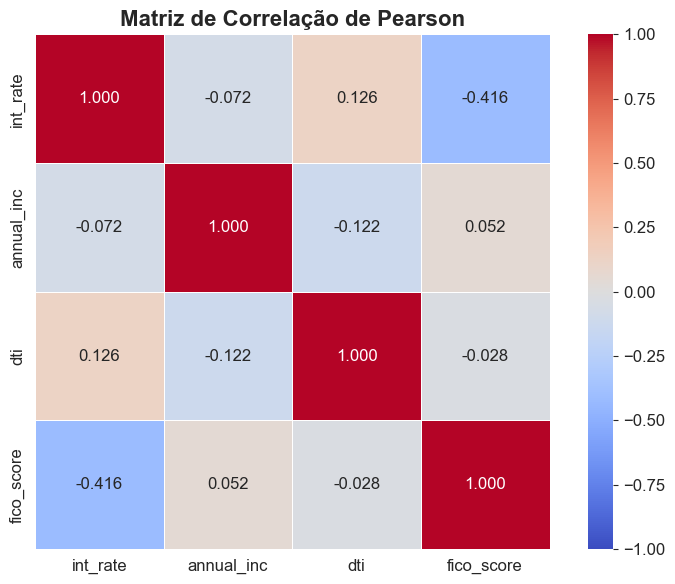

📊 Correlação de Pearson com int_rate:
   annual_inc      → r = -0.0716 (correlação fraca negativa)
   dti             → r = +0.1255 (correlação fraca positiva)
   fico_score      → r = -0.4157 (correlação moderada negativa)


In [13]:
# =============================================================================
# 8. MATRIZ DE CORRELAÇÃO (HEATMAP)
# =============================================================================

# Calcular a matriz de correlação de Pearson
# Pearson mede APENAS relações lineares. Se a relação for não-linear,
# a correlação pode ser baixa mesmo que haja uma associação forte.
corr_matrix = df.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,         # Mostrar os valores numéricos
    fmt='.3f',          # 3 casas decimais
    cmap='coolwarm',    # Paleta: azul (negativo) → vermelho (positivo)
    center=0,           # Centralizar a escala no zero
    vmin=-1, vmax=1,    # Fixar limites
    square=True,
    linewidths=0.5,
    ax=ax
)
ax.set_title('Matriz de Correlação de Pearson', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Imprimir correlações específicas com int_rate ---
print("📊 Correlação de Pearson com int_rate:")
for col in ['annual_inc', 'dti', 'fico_score']:
    r = corr_matrix.loc[col, 'int_rate']
    forca = 'forte' if abs(r) > 0.5 else 'moderada' if abs(r) > 0.3 else 'fraca'
    direcao = 'negativa' if r < 0 else 'positiva'
    print(f"   {col:15s} → r = {r:+.4f} (correlação {forca} {direcao})")

---
## 9 · EDA — Scatter Plots (X vs `int_rate`)

Visualizamos graficamente a relação entre cada variável independente e a taxa de juros. A **linearidade visual** é a primeira premissa a ser verificada: se os pontos não seguirem uma tendência linear, a regressão linear simples pode não ser o modelo ideal.

Usamos `alpha` baixo nos pontos porque temos milhares de observações — sem transparência, o gráfico ficaria uma massa sólida.

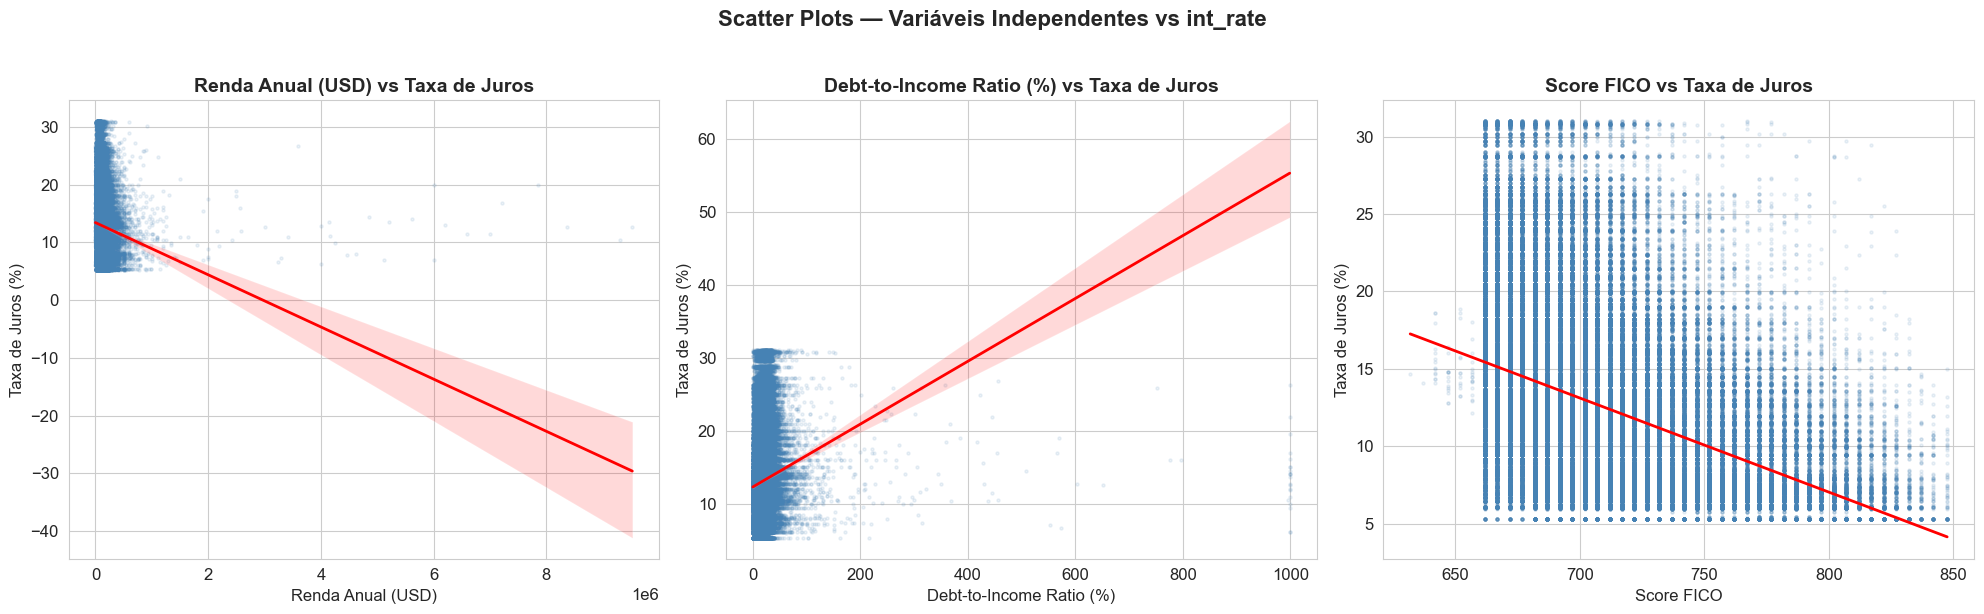

In [14]:
# =============================================================================
# 9. SCATTER PLOTS — X vs int_rate
# =============================================================================

variaveis = {
    'annual_inc': 'Renda Anual (USD)',
    'dti': 'Debt-to-Income Ratio (%)',
    'fico_score': 'Score FICO'
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (col, label) in zip(axes, variaveis.items()):
    # regplot = scatter + linha de regressão com intervalo de confiança
    sns.regplot(
        x=col, y='int_rate', data=df,
        ax=ax,
        scatter_kws={'alpha': 0.1, 's': 5, 'color': 'steelblue'},  # alpha baixo para volume grande
        line_kws={'color': 'red', 'linewidth': 2},
        ci=95  # Intervalo de confiança de 95%
    )
    ax.set_title(f'{label} vs Taxa de Juros', fontsize=14, fontweight='bold')
    ax.set_xlabel(label)
    ax.set_ylabel('Taxa de Juros (%)')

plt.suptitle('Scatter Plots — Variáveis Independentes vs int_rate', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 10 · Detecção e Remoção de Outliers (Método IQR)

**Outliers são perigosos para a regressão linear** porque o OLS (Ordinary Least Squares) minimiza a **soma dos quadrados** dos resíduos. Valores extremos geram resíduos enormes que, ao serem elevados ao quadrado, dominam a função de custo e "puxam" a reta na direção deles.

**Método utilizado — IQR (Interquartile Range):**
- $IQR = Q3 - Q1$ (distância entre o 3º e o 1º quartil)
- Limite inferior: $Q1 - 1.5 \times IQR$
- Limite superior: $Q3 + 1.5 \times IQR$
- Qualquer valor fora desses limites é considerado outlier.

Este é o mesmo critério usado em boxplots. É robusto e amplamente aceito na literatura.

📊 Shape ANTES da remoção de outliers: (299795, 4)


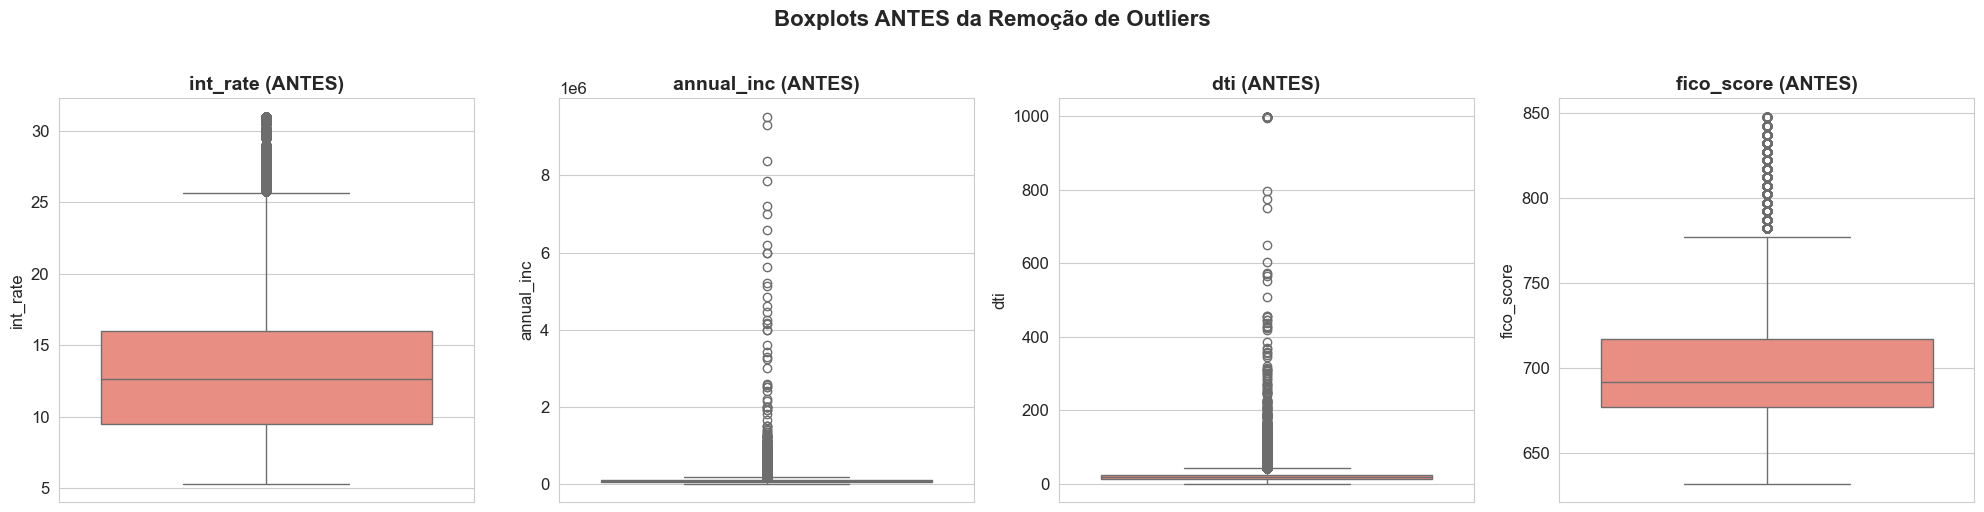


🔧 Removendo outliers por variável:
   int_rate        → Limites [-0.26, 25.74] | Removidos: 5,452
   annual_inc      → Limites [-25250.00, 164750.00] | Removidos: 14,374
   dti             → Limites [-6.62, 43.49] | Removidos: 2,646
   fico_score      → Limites [617.00, 777.00] | Removidos: 9,086

✅ Shape DEPOIS da remoção de outliers: (268237, 4)


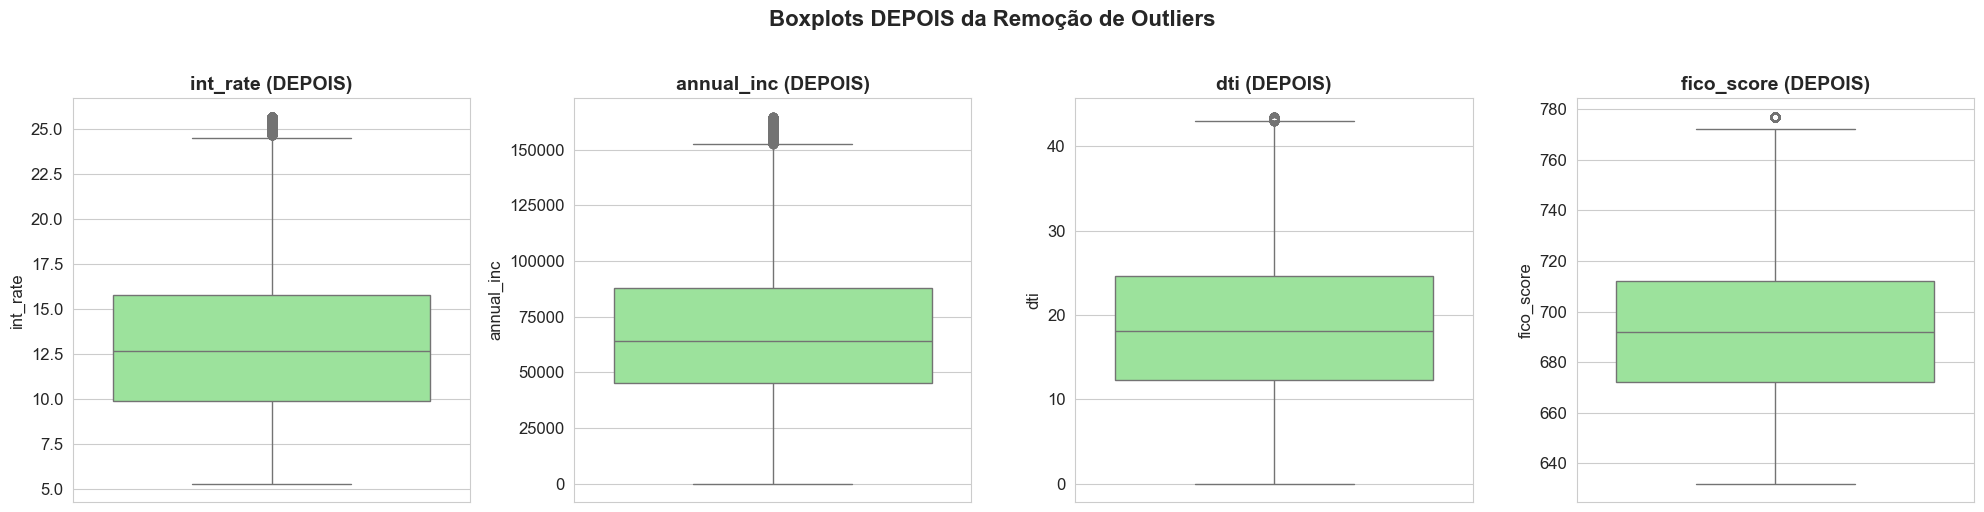

In [15]:
# =============================================================================
# 10. DETECÇÃO E REMOÇÃO DE OUTLIERS — MÉTODO IQR
# =============================================================================

print(f"📊 Shape ANTES da remoção de outliers: {df.shape}")

# --- Boxplots ANTES ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, col in zip(axes, ['int_rate', 'annual_inc', 'dti', 'fico_score']):
    sns.boxplot(y=df[col], ax=ax, color='salmon')
    ax.set_title(f'{col} (ANTES)', fontweight='bold')
plt.suptitle('Boxplots ANTES da Remoção de Outliers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- Função para remoção de outliers via IQR ---
def remover_outliers_iqr(dataframe, coluna):
    """
    Remove outliers de uma coluna usando o método IQR (Interquartile Range).
    
    Matematicamente:
        - IQR = Q3 - Q1
        - Limite inferior = Q1 - 1.5 * IQR
        - Limite superior = Q3 + 1.5 * IQR
    
    Retorna o DataFrame filtrado e a quantidade de outliers removidos.
    """
    Q1 = dataframe[coluna].quantile(0.25)
    Q3 = dataframe[coluna].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    antes = len(dataframe)
    dataframe = dataframe[(dataframe[coluna] >= lower) & (dataframe[coluna] <= upper)]
    removidos = antes - len(dataframe)
    
    print(f"   {coluna:15s} → Limites [{lower:.2f}, {upper:.2f}] | Removidos: {removidos:,}")
    return dataframe

# --- Aplicar para cada variável ---
print("\n🔧 Removendo outliers por variável:")
for col in ['int_rate', 'annual_inc', 'dti', 'fico_score']:
    df = remover_outliers_iqr(df, col)

print(f"\n✅ Shape DEPOIS da remoção de outliers: {df.shape}")

# --- Boxplots DEPOIS ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, col in zip(axes, ['int_rate', 'annual_inc', 'dti', 'fico_score']):
    sns.boxplot(y=df[col], ax=ax, color='lightgreen')
    ax.set_title(f'{col} (DEPOIS)', fontweight='bold')
plt.suptitle('Boxplots DEPOIS da Remoção de Outliers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 11 · Divisão dos Dados — Train/Test Split (80/20)

Dividimos os dados em **treino (80%)** e **teste (20%)** para cada par (X, y):

- **Treino:** usado para estimar os coeficientes da regressão (β₀, β₁).
- **Teste:** usado para avaliar o modelo em dados que ele **nunca viu** (prevenção de overfitting).

A divisão é feita via **permutação aleatória com NumPy**, garantindo reprodutibilidade (seed fixa).

> ⚠️ **A divisão é feita APÓS a remoção de outliers** para evitar *data leakage* (contaminação do teste com informações do pré-processamento).

In [16]:
# =============================================================================
# 11. DIVISÃO DOS DADOS — TRAIN/TEST SPLIT (80/20)
# =============================================================================

# Variável alvo (y) — a mesma para os 3 modelos
y = df['int_rate'].values

# --- Modelo 1: annual_inc → int_rate ---
X1 = df[['annual_inc']].values  # Formato 2D
X1_train, X1_test, y1_train, y1_test = train_test_split_manual(
    X1, y, test_size=0.2, random_state=RANDOM_STATE
)

# --- Modelo 2: dti → int_rate ---
X2 = df[['dti']].values
X2_train, X2_test, y2_train, y2_test = train_test_split_manual(
    X2, y, test_size=0.2, random_state=RANDOM_STATE
)

# --- Modelo 3: fico_score → int_rate ---
X3 = df[['fico_score']].values
X3_train, X3_test, y3_train, y3_test = train_test_split_manual(
    X3, y, test_size=0.2, random_state=RANDOM_STATE
)

# --- Verificar shapes ---
print("📋 Shapes dos conjuntos de dados:")
print(f"{'Modelo':<12} {'X_train':>10} {'X_test':>10} {'y_train':>10} {'y_test':>10}")
print("-" * 55)
for nome, xt, xte, yt, yte in [
    ('annual_inc', X1_train, X1_test, y1_train, y1_test),
    ('dti',        X2_train, X2_test, y2_train, y2_test),
    ('fico_score', X3_train, X3_test, y3_train, y3_test),
]:
    print(f"{nome:<12} {str(xt.shape):>10} {str(xte.shape):>10} {str(yt.shape):>10} {str(yte.shape):>10}")

print(f"\n✅ Dados divididos: 80% treino / 20% teste (random_state={RANDOM_STATE})")

📋 Shapes dos conjuntos de dados:
Modelo          X_train     X_test    y_train     y_test
-------------------------------------------------------
annual_inc   (214589, 1) (53648, 1)  (214589,)   (53648,)
dti          (214589, 1) (53648, 1)  (214589,)   (53648,)
fico_score   (214589, 1) (53648, 1)  (214589,)   (53648,)

✅ Dados divididos: 80% treino / 20% teste (random_state=42)


---
# 🔷 MODELO 1: `annual_inc` → `int_rate`
## Renda Anual como Preditora da Taxa de Juros

**Hipótese de negócio:** Clientes com **maior renda anual** representam menor risco de inadimplência, portanto o banco deveria cobrar **juros menores**. Esperamos um coeficiente β₁ **negativo**.

**Equação do modelo:**

$$\hat{y} = \beta_0 + \beta_1 \cdot \text{annual\_inc}$$

Onde:
- $\hat{y}$ = taxa de juros prevista (%)
- $\beta_0$ = intercepto (juros quando renda = 0, interpretação teórica)
- $\beta_1$ = variação na taxa de juros para cada dólar a mais de renda

---

### 12 · Modelo 1: Regressão OLS (statsmodels)

In [17]:
# =============================================================================
# 12. MODELO 1 — annual_inc → int_rate (STATSMODELS OLS)
# =============================================================================
# O statsmodels exige que adicionemos uma coluna de constante (1's) ao X para
# que o modelo estime o intercepto (β₀). Sem isso, a reta seria forçada a
# passar pela origem, o que não faz sentido para nosso problema.

X1_train_sm = sm.add_constant(X1_train)  # Adiciona coluna de 1's
X1_test_sm  = sm.add_constant(X1_test)

# --- Ajustar o modelo OLS ---
# OLS = Ordinary Least Squares (Mínimos Quadrados Ordinários)
# É o método que encontra β₀ e β₁ minimizando a soma dos quadrados dos resíduos:
# min Σ(yᵢ - ŷᵢ)² = min Σ(yᵢ - β₀ - β₁·xᵢ)²
modelo1_ols = sm.OLS(y1_train, X1_train_sm).fit()

# --- Exibir o sumário estatístico completo ---
# Este é o "coração" da análise estatística: p-values, R², F-statistic, etc.
print("=" * 70)
print("MODELO 1: annual_inc → int_rate (OLS Summary)")
print("=" * 70)
print(modelo1_ols.summary())

MODELO 1: annual_inc → int_rate (OLS Summary)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2482.
Date:                Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:00:44   Log-Likelihood:            -6.1962e+05
No. Observations:              214589   AIC:                         1.239e+06
Df Residuals:                  214587   BIC:                         1.239e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

### 13 · Modelo 1: Previsões e Métricas de Avaliação

Usando os coeficientes estimados pelo OLS, fazemos previsões no conjunto de teste e calculamos as métricas R², RMSE e MAE manualmente com NumPy.

📐 Coeficientes (OLS statsmodels):
   β₀ (intercepto):  14.064222
   β₁ (annual_inc):  -0.0000148554

📊 Métricas no Conjunto de Teste:
   R² (Coef. Determinação): 0.011064
   RMSE:                    4.3261%
   MAE:                     3.4755%


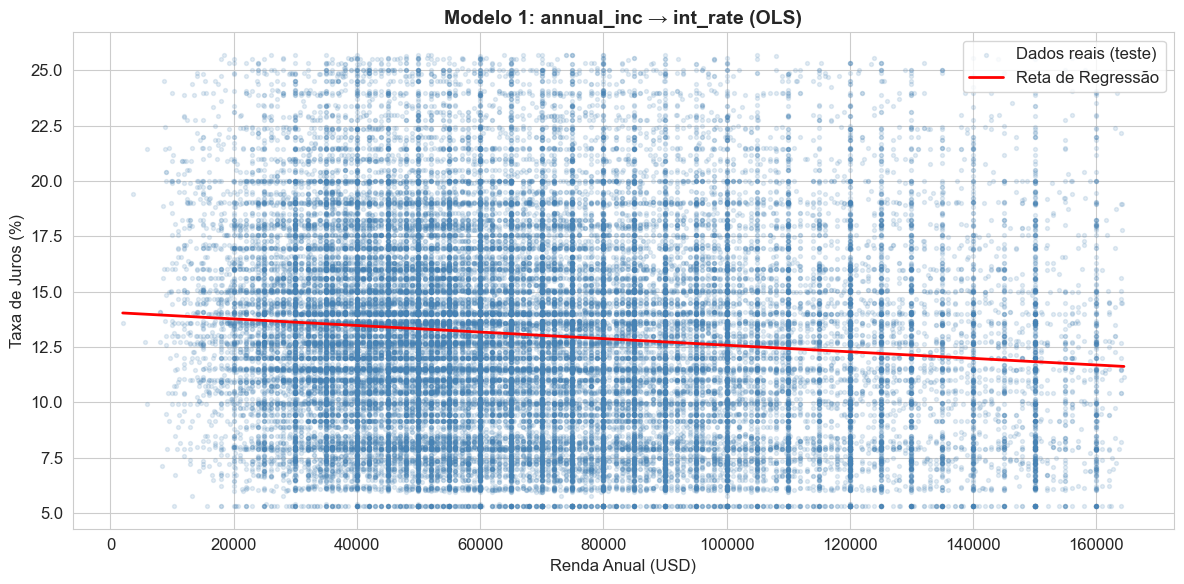

In [18]:
# =============================================================================
# 13. MODELO 1 — annual_inc → int_rate (PREVISÕES E MÉTRICAS)
# =============================================================================

# --- Coeficientes do OLS ---
beta0_m1 = modelo1_ols.params[0]  # Intercepto
beta1_m1 = modelo1_ols.params[1]  # Coeficiente de annual_inc

print("📐 Coeficientes (OLS statsmodels):")
print(f"   β₀ (intercepto):  {beta0_m1:.6f}")
print(f"   β₁ (annual_inc):  {beta1_m1:.10f}")

# --- Previsões no conjunto de teste ---
y1_pred = modelo1_ols.predict(X1_test_sm)

# --- Métricas de avaliação (cálculo manual) ---
r2_m1   = r2_score_manual(y1_test, y1_pred)
rmse_m1 = rmse_manual(y1_test, y1_pred)
mae_m1  = mae_manual(y1_test, y1_pred)

print(f"\n📊 Métricas no Conjunto de Teste:")
print(f"   R² (Coef. Determinação): {r2_m1:.6f}")
print(f"   RMSE:                    {rmse_m1:.4f}%")
print(f"   MAE:                     {mae_m1:.4f}%")

# --- Scatter Plot com reta de regressão ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(X1_test, y1_test, alpha=0.15, s=8, color='steelblue', label='Dados reais (teste)')
# Reta: ordenamos X_test para que a linha seja contínua
sorted_idx = X1_test.flatten().argsort()
ax.plot(X1_test.flatten()[sorted_idx], y1_pred[sorted_idx],
        color='red', linewidth=2, label='Reta de Regressão')
ax.set_title('Modelo 1: annual_inc → int_rate (OLS)', fontsize=14, fontweight='bold')
ax.set_xlabel('Renda Anual (USD)')
ax.set_ylabel('Taxa de Juros (%)')
ax.legend()
plt.tight_layout()
plt.show()

### 14 · Modelo 1: Rede Neural Simples (TensorFlow/Keras)

Construímos uma rede neural com **um único neurônio linear** para demonstrar a equivalência matemática:

$$\text{Rede Neural:} \quad \hat{y} = W \cdot x + b$$
$$\text{Regressão Linear:} \quad \hat{y} = \beta_1 \cdot x + \beta_0$$

São a **mesma equação**! O neurônio aprende $W \approx \beta_1$ e $b \approx \beta_0$ via gradient descent.

> **Padronização:** Redes neurais convergem **muito melhor** quando os dados estão na mesma escala. Usamos padronização z-score ($z = \frac{x - \mu}{\sigma}$) antes de treinar. Depois, desnormalizamos os pesos para comparar com os coeficientes da regressão clássica.

⏳ Treinando Rede Neural — Modelo 1 (annual_inc → int_rate)...
✅ Treino concluído!
✅ Treino concluído!


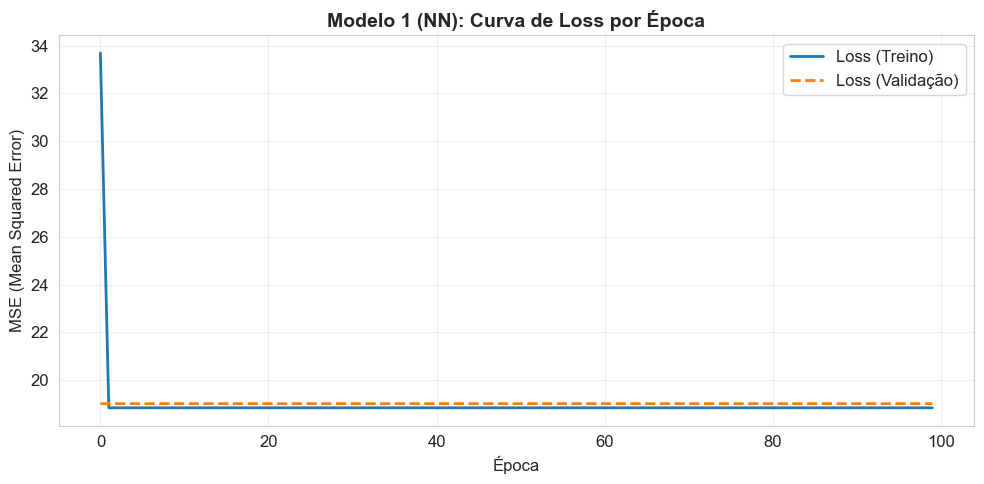


📐 Pesos da Rede Neural (desnormalizados):
   W (≈ β₁): -0.0000163581
   b (≈ β₀): 14.132795

   Comparação com OLS (statsmodels):
   β₁ (OLS): -0.0000148554
   β₀ (OLS): 14.064222

📊 Métricas (Rede Neural) no Conjunto de Teste:
   R²:   0.010987
   RMSE: 4.3262%
   MAE:  3.4731%

📊 Métricas (Rede Neural) no Conjunto de Teste:
   R²:   0.010987
   RMSE: 4.3262%
   MAE:  3.4731%


In [19]:
# =============================================================================
# 14. MODELO 1 — annual_inc → int_rate (REDE NEURAL - TENSORFLOW/KERAS)
# =============================================================================

# --- Padronização z-score manual ---
# A rede neural é sensível à escala dos dados. annual_inc está na faixa de
# dezenas/centenas de milhares, enquanto int_rate está entre 5 e 25.
# Sem padronização, o gradiente pode explodir ou convergir muito lentamente.
X1_train_scaled, X1_test_scaled, mean1, std1 = standard_scale(X1_train, X1_test)

# --- Construir a rede neural ---
# Arquitetura: 1 neurônio de entrada → 1 neurônio de saída (linear)
# Isso é ALGEBRICAMENTE IDÊNTICO à regressão linear: ŷ = W·x + b
tf.random.set_seed(RANDOM_STATE)

modelo1_nn = Sequential([
    Dense(1, input_shape=(1,), activation='linear')  # 1 neurônio, ativação linear
])

# --- Compilar ---
# Optimizer: Adam (variante eficiente do gradient descent)
# Loss: MSE (Mean Squared Error) — mesma função de custo do OLS!
modelo1_nn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

# --- Treinar ---
print("⏳ Treinando Rede Neural — Modelo 1 (annual_inc → int_rate)...")
history1 = modelo1_nn.fit(
    X1_train_scaled, y1_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,  # 10% do treino para validação interna
    verbose=0  # Silencioso (mostramos a curva de loss depois)
)
print("✅ Treino concluído!")

# --- Curvas de Loss (Treino vs Validação) ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history1.history['loss'], label='Loss (Treino)', linewidth=2)
ax.plot(history1.history['val_loss'], label='Loss (Validação)', linewidth=2, linestyle='--')
ax.set_title('Modelo 1 (NN): Curva de Loss por Época', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('MSE (Mean Squared Error)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Extrair e desnormalizar pesos ---
# Os pesos da rede foram aprendidos no espaço padronizado (z-score).
# Para comparar com β₁ e β₀ do OLS, precisamos desnormalizar:
#   β₁_real = W / σ_x
#   β₀_real = b - W * μ_x / σ_x
W_scaled, b_scaled = modelo1_nn.get_weights()
W_real = W_scaled[0][0] / std1[0]
b_real = b_scaled[0] - W_scaled[0][0] * mean1[0] / std1[0]

print(f"\n📐 Pesos da Rede Neural (desnormalizados):")
print(f"   W (≈ β₁): {W_real:.10f}")
print(f"   b (≈ β₀): {b_real:.6f}")
print(f"\n   Comparação com OLS (statsmodels):")
print(f"   β₁ (OLS): {beta1_m1:.10f}")
print(f"   β₀ (OLS): {beta0_m1:.6f}")

# --- Métricas no conjunto de teste ---
y1_pred_nn = modelo1_nn.predict(X1_test_scaled, verbose=0).flatten()
r2_m1_nn   = r2_score_manual(y1_test, y1_pred_nn)
rmse_m1_nn = rmse_manual(y1_test, y1_pred_nn)
mae_m1_nn  = mae_manual(y1_test, y1_pred_nn)

print(f"\n📊 Métricas (Rede Neural) no Conjunto de Teste:")
print(f"   R²:   {r2_m1_nn:.6f}")
print(f"   RMSE: {rmse_m1_nn:.4f}%")
print(f"   MAE:  {mae_m1_nn:.4f}%")

### 15 · Modelo 1: Validação das Premissas — Linearidade e Homocedasticidade

As duas premissas mais importantes da regressão OLS que podemos verificar visualmente:

1. **Linearidade:** A relação entre X e Y deve ser linear. No gráfico de resíduos vs X, **não deve haver padrão curvilíneo**.
2. **Homocedasticidade:** A variância dos resíduos deve ser **constante** ao longo de ŷ. No gráfico de resíduos vs ŷ, os pontos devem estar distribuídos aleatoriamente, **sem formato de funil** (cone aberto = heterocedasticidade).

> ⚠️ Se houver **heterocedasticidade**, os erros-padrão dos coeficientes ficam enviesados → os p-values deixam de ser confiáveis → conclusões sobre significância estatística podem estar erradas.

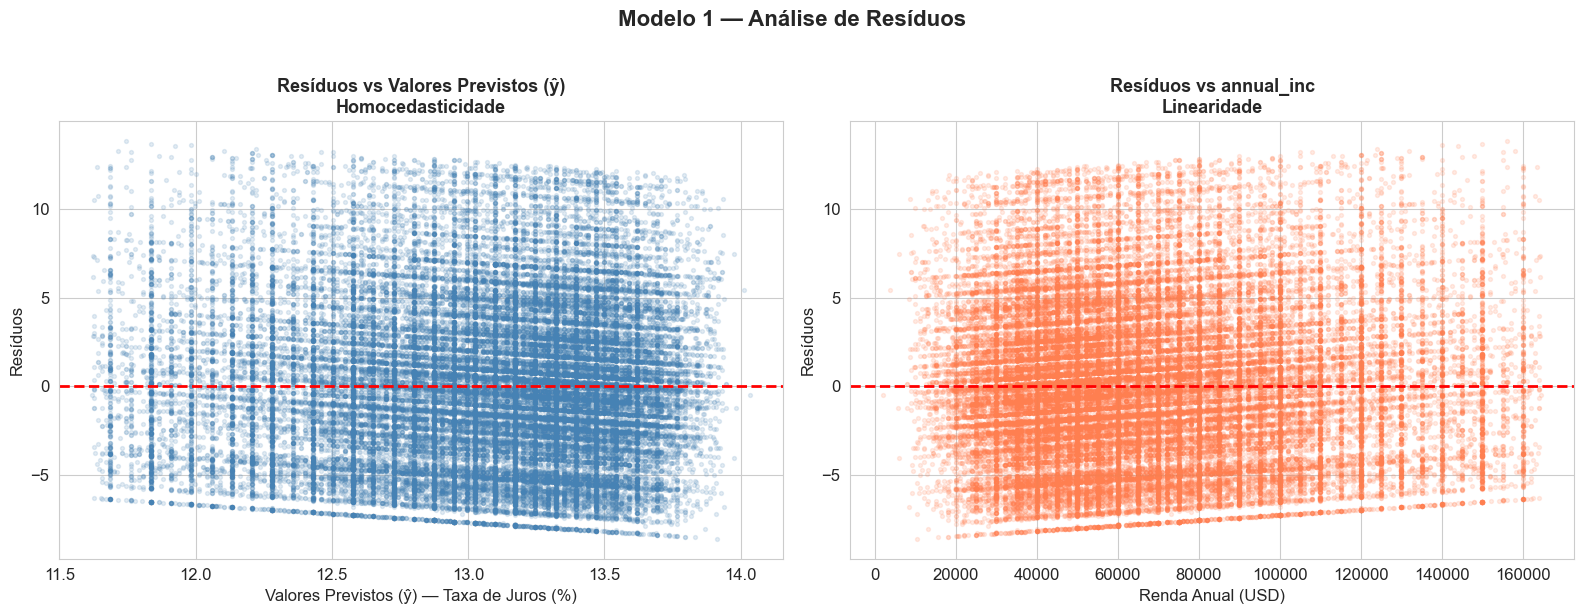

In [20]:
# =============================================================================
# 15. MODELO 1 — VALIDAÇÃO: LINEARIDADE E HOMOCEDASTICIDADE
# =============================================================================

# Calcular resíduos: diferença entre o valor real e o previsto
# Se o modelo fosse perfeito, todos os resíduos seriam zero.
residuos1 = y1_test - y1_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Resíduos vs Valores Previstos (ŷ) → Homocedasticidade ---
axes[0].scatter(y1_pred, residuos1, alpha=0.15, s=8, color='steelblue')
axes[0].axhline(y=0, color='red', linewidth=2, linestyle='--')
axes[0].set_title('Resíduos vs Valores Previstos (ŷ)\nHomocedasticidade', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Valores Previstos (ŷ) — Taxa de Juros (%)')
axes[0].set_ylabel('Resíduos')

# --- Plot 2: Resíduos vs X (annual_inc) → Linearidade ---
axes[1].scatter(X1_test, residuos1, alpha=0.15, s=8, color='coral')
axes[1].axhline(y=0, color='red', linewidth=2, linestyle='--')
axes[1].set_title('Resíduos vs annual_inc\nLinearidade', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Renda Anual (USD)')
axes[1].set_ylabel('Resíduos')

plt.suptitle('Modelo 1 — Análise de Resíduos', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 16 · Modelo 1: Validação das Premissas — Normalidade dos Resíduos

A premissa de **normalidade dos resíduos** garante que os intervalos de confiança e os p-values são válidos.

Ferramentas utilizadas:
- **Q-Q Plot** (Quantile-Quantile): se os pontos seguirem a linha de 45°, os resíduos são normais.
- **Teste de Shapiro-Wilk**: teste formal — $H_0$: os dados são normalmente distribuídos. Se $p > 0.05$, não rejeitamos $H_0$.

> **Atenção:** Com $n$ grande (>5000), Shapiro-Wilk tende a rejeitar $H_0$ por ser muito sensível a pequenos desvios. Nesse caso, o **Q-Q Plot visual** e o **Teorema Central do Limite** são argumentos mais convincentes.

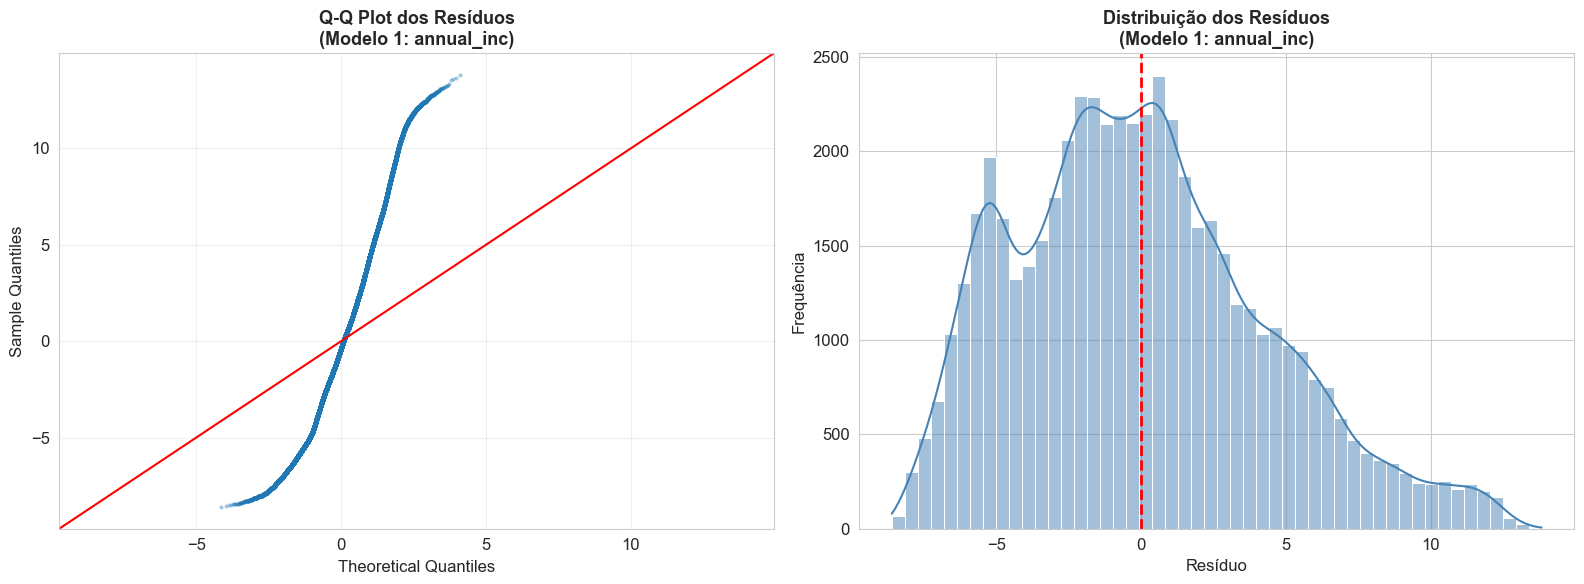

📊 Teste de Shapiro-Wilk (Modelo 1):
   Estatística W = 0.977843
   p-value       = 3.141774e-27
   ⚠️  Rejeitamos H₀: desvio da normalidade detectado (p < 0.05)
   → Com n grande, isso é esperado (Shapiro-Wilk é muito sensível).
   → O Q-Q Plot visual e o Teorema Central do Limite justificam a validade.


In [21]:
# =============================================================================
# 16. MODELO 1 — VALIDAÇÃO: NORMALIDADE DOS RESÍDUOS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Q-Q Plot ---
# Se os resíduos forem normais, os pontos se alinham à diagonal vermelha.
qqplot(residuos1, line='45', ax=axes[0], markersize=2, alpha=0.3)
axes[0].set_title('Q-Q Plot dos Resíduos\n(Modelo 1: annual_inc)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# --- Histograma dos Resíduos com KDE ---
sns.histplot(residuos1, kde=True, bins=50, color='steelblue', ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Distribuição dos Resíduos\n(Modelo 1: annual_inc)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Resíduo')
axes[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# --- Teste de Shapiro-Wilk ---
# O teste aceita no máximo 5000 observações. Se temos mais, usamos uma sub-amostra.
amostra_residuos1 = np.random.choice(residuos1, size=min(5000, len(residuos1)), replace=False)
stat_sw, p_sw = shapiro(amostra_residuos1)

print(f"📊 Teste de Shapiro-Wilk (Modelo 1):")
print(f"   Estatística W = {stat_sw:.6f}")
print(f"   p-value       = {p_sw:.6e}")
if p_sw > 0.05:
    print("   ✅ Não rejeitamos H₀: os resíduos seguem distribuição normal (p > 0.05)")
else:
    print("   ⚠️  Rejeitamos H₀: desvio da normalidade detectado (p < 0.05)")
    print("   → Com n grande, isso é esperado (Shapiro-Wilk é muito sensível).")
    print("   → O Q-Q Plot visual e o Teorema Central do Limite justificam a validade.")

### 17 · Modelo 1: Validação das Premissas — Independência (Durbin-Watson)

A estatística de **Durbin-Watson** testa se os resíduos são **autocorrelacionados** (se o erro de uma observação influencia o erro da próxima).

| Valor DW | Interpretação |
|---|---|
| ≈ 2.0 | ✅ Sem autocorrelação |
| ≈ 0.0 | ⚠️ Autocorrelação positiva forte |
| ≈ 4.0 | ⚠️ Autocorrelação negativa forte |

> Em dados **cross-section** (não temporais), a autocorrelação é menos comum. Mas verificamos por boa prática.

In [22]:
# =============================================================================
# 17. MODELO 1 — VALIDAÇÃO: INDEPENDÊNCIA DOS RESÍDUOS (DURBIN-WATSON)
# =============================================================================

# Calcular Durbin-Watson
# Usamos os resíduos do OLS no conjunto de treino (prática padrão com statsmodels)
dw1 = durbin_watson(modelo1_ols.resid)

print(f"📊 Estatística de Durbin-Watson (Modelo 1): {dw1:.4f}")
if 1.5 < dw1 < 2.5:
    print("   ✅ Valor próximo de 2 → Não há evidência de autocorrelação significativa.")
elif dw1 <= 1.5:
    print("   ⚠️  Valor baixo → Possível autocorrelação positiva.")
else:
    print("   ⚠️  Valor alto → Possível autocorrelação negativa.")

📊 Estatística de Durbin-Watson (Modelo 1): 2.0013
   ✅ Valor próximo de 2 → Não há evidência de autocorrelação significativa.


---
# 🔶 MODELO 2: `dti` → `int_rate`
## Debt-to-Income Ratio como Preditor da Taxa de Juros

**Hipótese de negócio:** Quanto **maior o DTI** (mais endividado em relação à renda), maior o risco de inadimplência → o banco cobra **juros mais altos**. Esperamos β₁ **positivo**.

**Equação do modelo:**

$$\hat{y} = \beta_0 + \beta_1 \cdot \text{dti}$$

---

### 18 · Modelo 2: Regressão OLS (statsmodels)

In [23]:
# =============================================================================
# 18. MODELO 2 — dti → int_rate (STATSMODELS OLS)
# =============================================================================

X2_train_sm = sm.add_constant(X2_train)
X2_test_sm  = sm.add_constant(X2_test)

# Ajustar OLS
modelo2_ols = sm.OLS(y2_train, X2_train_sm).fit()

print("=" * 70)
print("MODELO 2: dti → int_rate (OLS Summary)")
print("=" * 70)
print(modelo2_ols.summary())

MODELO 2: dti → int_rate (OLS Summary)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6067.
Date:                Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:33:04   Log-Likelihood:            -6.1786e+05
No. Observations:              214589   AIC:                         1.236e+06
Df Residuals:                  214587   BIC:                         1.236e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

### 19 · Modelo 2: Previsões e Métricas de Avaliação

📐 Coeficientes (OLS statsmodels):
   β₀ (intercepto): 11.444881
   β₁ (dti):        0.085506

📊 Métricas no Conjunto de Teste:
   R²:   0.025873
   RMSE: 4.2936%
   MAE:  3.4483%


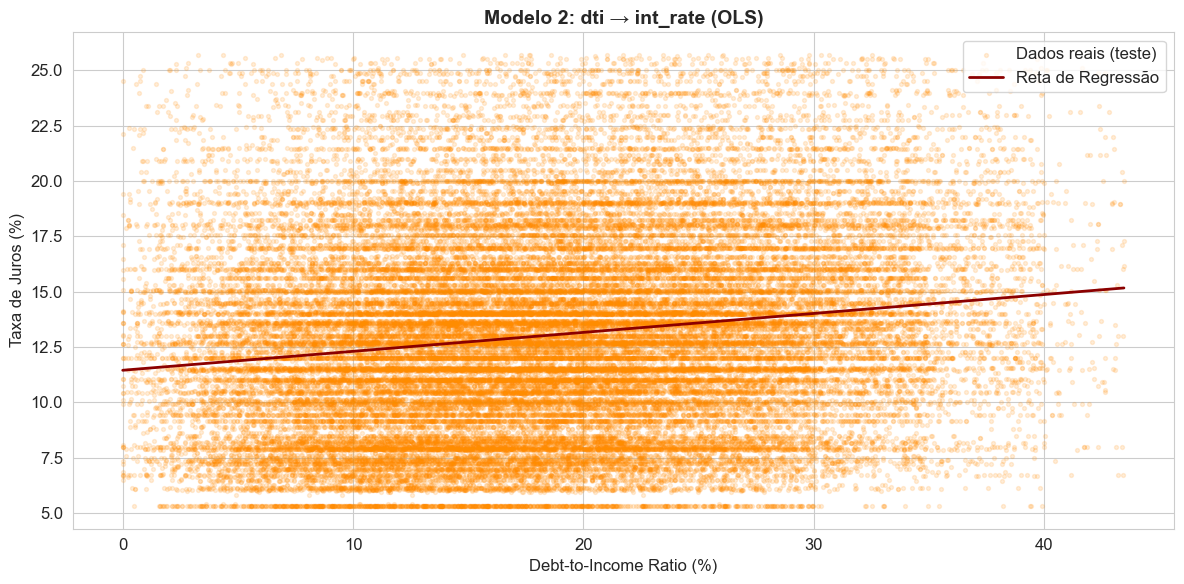

In [24]:
# =============================================================================
# 19. MODELO 2 — dti → int_rate (PREVISÕES E MÉTRICAS)
# =============================================================================

# Coeficientes do OLS
beta0_m2 = modelo2_ols.params[0]
beta1_m2 = modelo2_ols.params[1]

print("📐 Coeficientes (OLS statsmodels):")
print(f"   β₀ (intercepto): {beta0_m2:.6f}")
print(f"   β₁ (dti):        {beta1_m2:.6f}")

# Previsões
y2_pred = modelo2_ols.predict(X2_test_sm)

# Métricas
r2_m2   = r2_score_manual(y2_test, y2_pred)
rmse_m2 = rmse_manual(y2_test, y2_pred)
mae_m2  = mae_manual(y2_test, y2_pred)

print(f"\n📊 Métricas no Conjunto de Teste:")
print(f"   R²:   {r2_m2:.6f}")
print(f"   RMSE: {rmse_m2:.4f}%")
print(f"   MAE:  {mae_m2:.4f}%")

# --- Scatter Plot com reta ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(X2_test, y2_test, alpha=0.15, s=8, color='darkorange', label='Dados reais (teste)')
sorted_idx = X2_test.flatten().argsort()
ax.plot(X2_test.flatten()[sorted_idx], y2_pred[sorted_idx],
        color='darkred', linewidth=2, label='Reta de Regressão')
ax.set_title('Modelo 2: dti → int_rate (OLS)', fontsize=14, fontweight='bold')
ax.set_xlabel('Debt-to-Income Ratio (%)')
ax.set_ylabel('Taxa de Juros (%)')
ax.legend()
plt.tight_layout()
plt.show()

### 20 · Modelo 2: Rede Neural Simples (TensorFlow/Keras)

⏳ Treinando Rede Neural — Modelo 2 (dti → int_rate)...
✅ Treino concluído!
✅ Treino concluído!


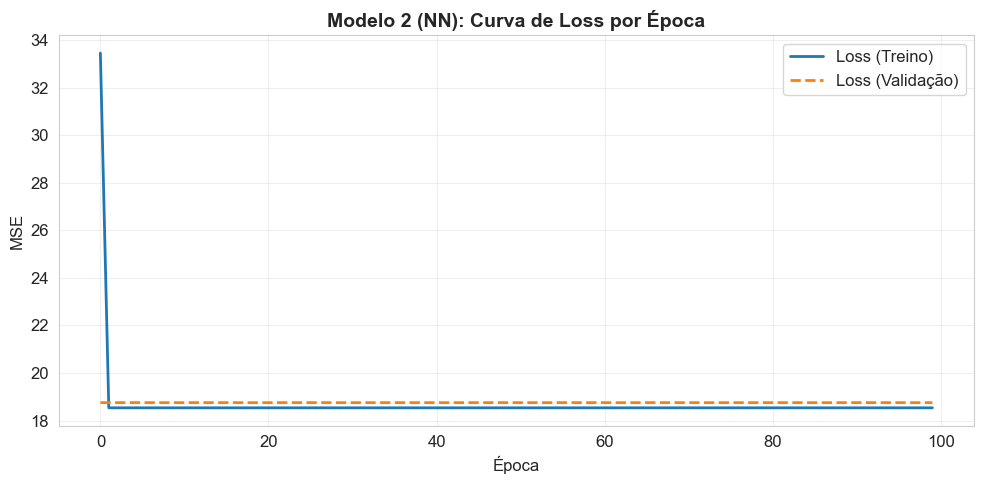


📐 Pesos da Rede Neural (desnormalizados):
   W (≈ β₁): 0.082555
   b (≈ β₀): 11.470876
   Comparação OLS → β₁: 0.085506, β₀: 11.444881

📊 Métricas (Rede Neural):
   R²:   0.025973
   RMSE: 4.2933%
   MAE:  3.4464%

📊 Métricas (Rede Neural):
   R²:   0.025973
   RMSE: 4.2933%
   MAE:  3.4464%


In [25]:
# =============================================================================
# 20. MODELO 2 — dti → int_rate (REDE NEURAL - TENSORFLOW/KERAS)
# =============================================================================

# Padronizar dti (z-score manual)
X2_train_scaled, X2_test_scaled, mean2, std2 = standard_scale(X2_train, X2_test)

# Construir rede neural — mesma arquitetura (1 neurônio linear)
tf.random.set_seed(RANDOM_STATE)
modelo2_nn = Sequential([
    Dense(1, input_shape=(1,), activation='linear')
])
modelo2_nn.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Treinar
print("⏳ Treinando Rede Neural — Modelo 2 (dti → int_rate)...")
history2 = modelo2_nn.fit(
    X2_train_scaled, y2_train,
    epochs=100, batch_size=32,
    validation_split=0.1, verbose=0
)
print("✅ Treino concluído!")

# Curva de Loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history2.history['loss'], label='Loss (Treino)', linewidth=2)
ax.plot(history2.history['val_loss'], label='Loss (Validação)', linewidth=2, linestyle='--')
ax.set_title('Modelo 2 (NN): Curva de Loss por Época', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('MSE')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Desnormalizar pesos
W2_scaled, b2_scaled = modelo2_nn.get_weights()
W2_real = W2_scaled[0][0] / std2[0]
b2_real = b2_scaled[0] - W2_scaled[0][0] * mean2[0] / std2[0]
print(f"\n📐 Pesos da Rede Neural (desnormalizados):")
print(f"   W (≈ β₁): {W2_real:.6f}")
print(f"   b (≈ β₀): {b2_real:.6f}")
print(f"   Comparação OLS → β₁: {beta1_m2:.6f}, β₀: {beta0_m2:.6f}")

# Métricas
y2_pred_nn = modelo2_nn.predict(X2_test_scaled, verbose=0).flatten()
r2_m2_nn   = r2_score_manual(y2_test, y2_pred_nn)
rmse_m2_nn = rmse_manual(y2_test, y2_pred_nn)
mae_m2_nn  = mae_manual(y2_test, y2_pred_nn)
print(f"\n📊 Métricas (Rede Neural):")
print(f"   R²:   {r2_m2_nn:.6f}")
print(f"   RMSE: {rmse_m2_nn:.4f}%")
print(f"   MAE:  {mae_m2_nn:.4f}%")

### 21 · Modelo 2: Validação das Premissas — Linearidade e Homocedasticidade

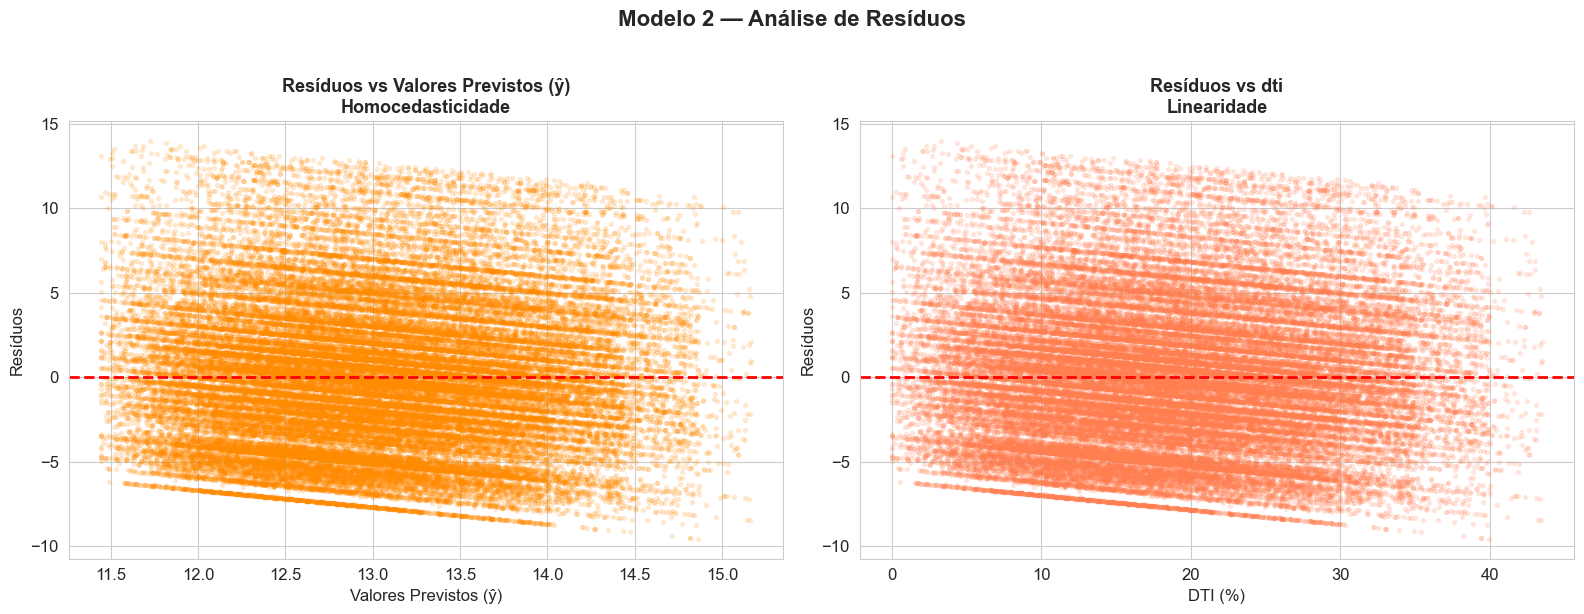

In [26]:
# =============================================================================
# 21. MODELO 2 — VALIDAÇÃO: LINEARIDADE E HOMOCEDASTICIDADE
# =============================================================================

residuos2 = y2_test - y2_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Resíduos vs Valores Previstos → Homocedasticidade
axes[0].scatter(y2_pred, residuos2, alpha=0.15, s=8, color='darkorange')
axes[0].axhline(y=0, color='red', linewidth=2, linestyle='--')
axes[0].set_title('Resíduos vs Valores Previstos (ŷ)\nHomocedasticidade', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Valores Previstos (ŷ)')
axes[0].set_ylabel('Resíduos')

# Resíduos vs X → Linearidade
axes[1].scatter(X2_test, residuos2, alpha=0.15, s=8, color='coral')
axes[1].axhline(y=0, color='red', linewidth=2, linestyle='--')
axes[1].set_title('Resíduos vs dti\nLinearidade', fontsize=13, fontweight='bold')
axes[1].set_xlabel('DTI (%)')
axes[1].set_ylabel('Resíduos')

plt.suptitle('Modelo 2 — Análise de Resíduos', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 22 · Modelo 2: Validação das Premissas — Normalidade dos Resíduos (Q-Q Plot + Shapiro-Wilk)

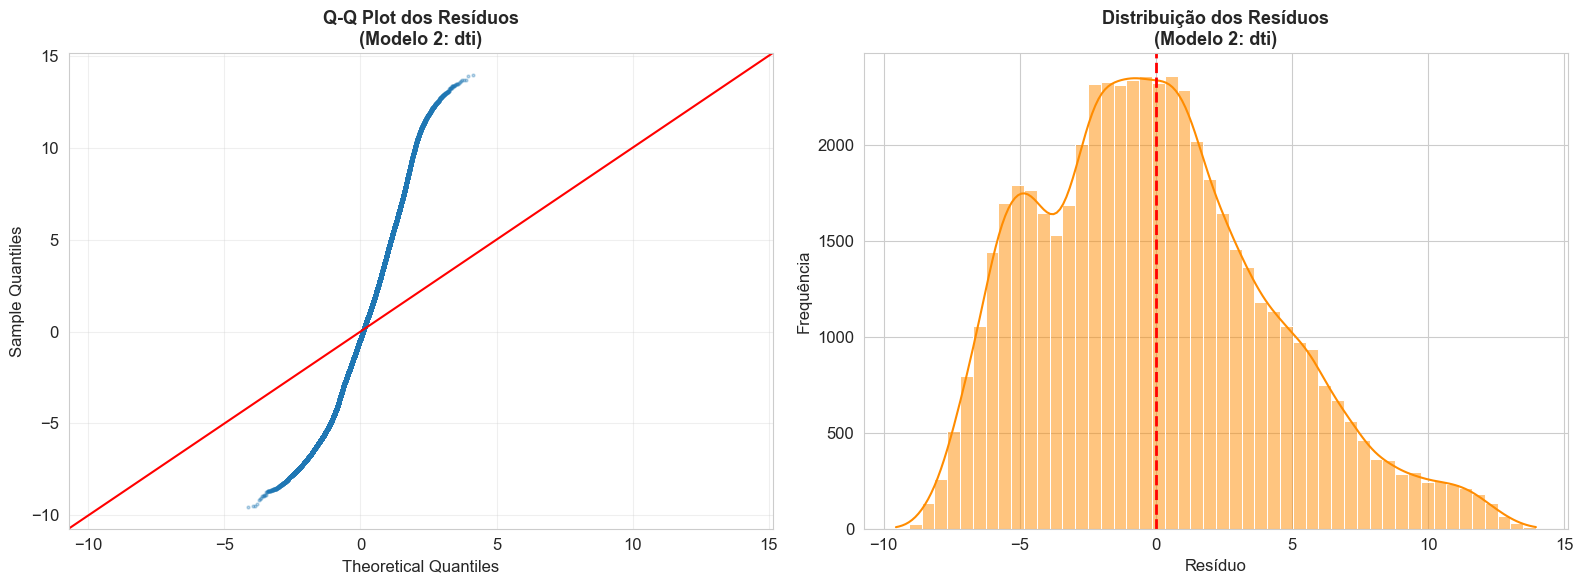

📊 Teste de Shapiro-Wilk (Modelo 2):
   Estatística W = 0.978289
   p-value       = 5.595941e-27
   ⚠️  H₀ rejeitada — desvio detectado (esperado com n grande).


In [27]:
# =============================================================================
# 22. MODELO 2 — VALIDAÇÃO: NORMALIDADE DOS RESÍDUOS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Q-Q Plot
qqplot(residuos2, line='45', ax=axes[0], markersize=2, alpha=0.3)
axes[0].set_title('Q-Q Plot dos Resíduos\n(Modelo 2: dti)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Histograma
sns.histplot(residuos2, kde=True, bins=50, color='darkorange', ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Distribuição dos Resíduos\n(Modelo 2: dti)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Resíduo')
axes[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# Shapiro-Wilk
amostra_residuos2 = np.random.choice(residuos2, size=min(5000, len(residuos2)), replace=False)
stat_sw2, p_sw2 = shapiro(amostra_residuos2)
print(f"📊 Teste de Shapiro-Wilk (Modelo 2):")
print(f"   Estatística W = {stat_sw2:.6f}")
print(f"   p-value       = {p_sw2:.6e}")
if p_sw2 > 0.05:
    print("   ✅ Não rejeitamos H₀: resíduos normais.")
else:
    print("   ⚠️  H₀ rejeitada — desvio detectado (esperado com n grande).")

### 23 · Modelo 2: Validação das Premissas — Independência (Durbin-Watson)

In [28]:
# =============================================================================
# 23. MODELO 2 — VALIDAÇÃO: INDEPENDÊNCIA (DURBIN-WATSON)
# =============================================================================

dw2 = durbin_watson(modelo2_ols.resid)
print(f"📊 Estatística de Durbin-Watson (Modelo 2): {dw2:.4f}")
if 1.5 < dw2 < 2.5:
    print("   ✅ Sem autocorrelação significativa.")
elif dw2 <= 1.5:
    print("   ⚠️  Possível autocorrelação positiva.")
else:
    print("   ⚠️  Possível autocorrelação negativa.")

📊 Estatística de Durbin-Watson (Modelo 2): 2.0027
   ✅ Sem autocorrelação significativa.


---
# 🔷 MODELO 3: `fico_score` → `int_rate`
## Score FICO como Preditor da Taxa de Juros

**Hipótese de negócio:** O FICO score é o **principal indicador de risco de crédito** nos EUA. Quanto **maior o score**, menor o risco → o banco cobra **juros menores**. Esperamos β₁ **fortemente negativo**.

Este deve ser o modelo com **melhor R²** dentre os três, pois o FICO score é explicitamente usado pelo Lending Club para definir os grades (A–G) que determinam as faixas de taxa de juros.

**Equação:**

$$\hat{y} = \beta_0 + \beta_1 \cdot \text{fico\_score}$$

---

### 24 · Modelo 3: Regressão OLS (statsmodels)

In [29]:
# =============================================================================
# 24. MODELO 3 — fico_score → int_rate (STATSMODELS OLS)
# =============================================================================

X3_train_sm = sm.add_constant(X3_train)
X3_test_sm  = sm.add_constant(X3_test)

modelo3_ols = sm.OLS(y3_train, X3_train_sm).fit()

print("=" * 70)
print("MODELO 3: fico_score → int_rate (OLS Summary)")
print("=" * 70)
print(modelo3_ols.summary())

MODELO 3: fico_score → int_rate (OLS Summary)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                 3.976e+04
Date:                Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:54:23   Log-Likelihood:            -6.0261e+05
No. Observations:              214589   AIC:                         1.205e+06
Df Residuals:                  214587   BIC:                         1.205e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

### 25 · Modelo 3: Previsões e Métricas de Avaliação

📐 Coeficientes (OLS statsmodels):
   β₀ (intercepto):  56.215086
   β₁ (fico_score):  -0.061947

📊 Métricas no Conjunto de Teste:
   R²:   0.155121
   RMSE: 3.9986%
   MAE:  3.1946%


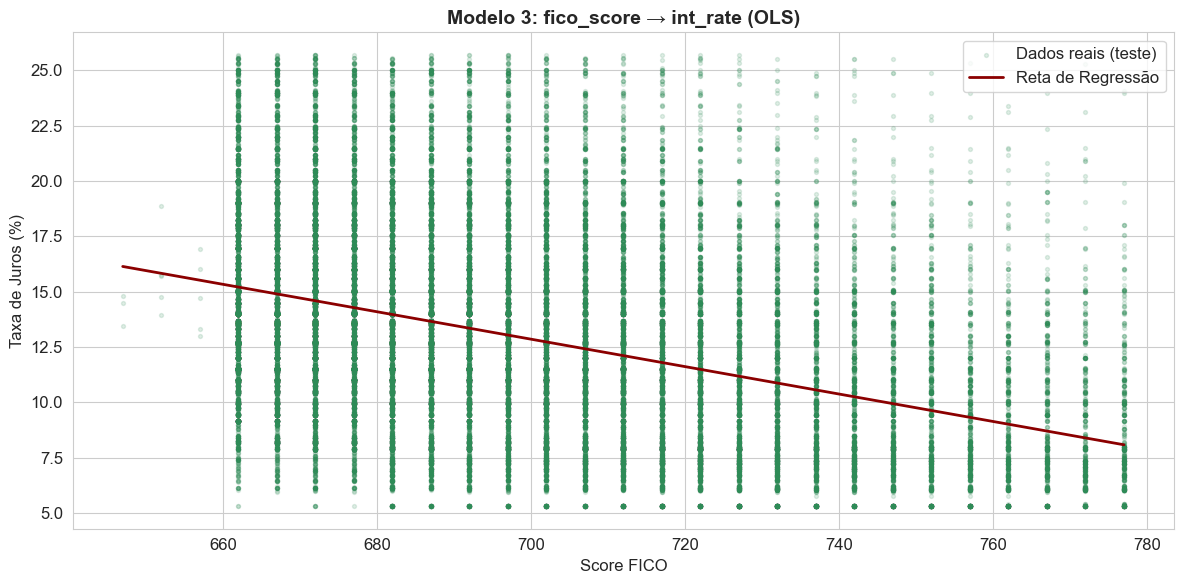

In [30]:
# =============================================================================
# 25. MODELO 3 — fico_score → int_rate (PREVISÕES E MÉTRICAS)
# =============================================================================

# Coeficientes do OLS
beta0_m3 = modelo3_ols.params[0]
beta1_m3 = modelo3_ols.params[1]

print("📐 Coeficientes (OLS statsmodels):")
print(f"   β₀ (intercepto):  {beta0_m3:.6f}")
print(f"   β₁ (fico_score):  {beta1_m3:.6f}")

# Previsões
y3_pred = modelo3_ols.predict(X3_test_sm)

# Métricas
r2_m3   = r2_score_manual(y3_test, y3_pred)
rmse_m3 = rmse_manual(y3_test, y3_pred)
mae_m3  = mae_manual(y3_test, y3_pred)

print(f"\n📊 Métricas no Conjunto de Teste:")
print(f"   R²:   {r2_m3:.6f}")
print(f"   RMSE: {rmse_m3:.4f}%")
print(f"   MAE:  {mae_m3:.4f}%")

# Scatter Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(X3_test, y3_test, alpha=0.15, s=8, color='seagreen', label='Dados reais (teste)')
sorted_idx = X3_test.flatten().argsort()
ax.plot(X3_test.flatten()[sorted_idx], y3_pred[sorted_idx],
        color='darkred', linewidth=2, label='Reta de Regressão')
ax.set_title('Modelo 3: fico_score → int_rate (OLS)', fontsize=14, fontweight='bold')
ax.set_xlabel('Score FICO')
ax.set_ylabel('Taxa de Juros (%)')
ax.legend()
plt.tight_layout()
plt.show()

### 26 · Modelo 3: Rede Neural Simples (TensorFlow/Keras)

⏳ Treinando Rede Neural — Modelo 3 (fico_score → int_rate)...
✅ Treino concluído!
✅ Treino concluído!


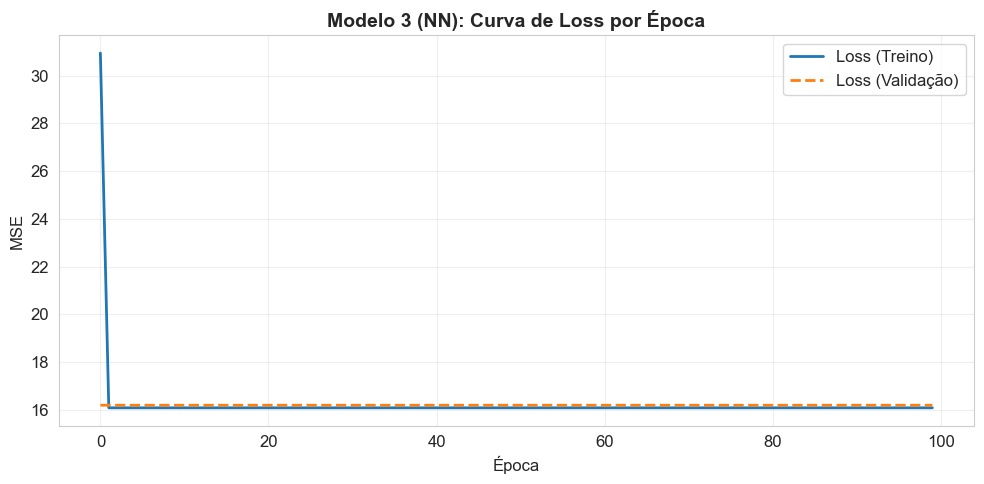


📐 Pesos da Rede Neural (desnormalizados):
   W (≈ β₁): -0.057167
   b (≈ β₀): 52.854059
   Comparação OLS → β₁: -0.061947, β₀: 56.215086

📊 Métricas (Rede Neural):
   R²:   0.154453
   RMSE: 4.0002%
   MAE:  3.1962%

📊 Métricas (Rede Neural):
   R²:   0.154453
   RMSE: 4.0002%
   MAE:  3.1962%


In [31]:
# =============================================================================
# 26. MODELO 3 — fico_score → int_rate (REDE NEURAL - TENSORFLOW/KERAS)
# =============================================================================

# Padronizar fico_score (z-score manual)
X3_train_scaled, X3_test_scaled, mean3, std3 = standard_scale(X3_train, X3_test)

# Construir rede neural
tf.random.set_seed(RANDOM_STATE)
modelo3_nn = Sequential([
    Dense(1, input_shape=(1,), activation='linear')
])
modelo3_nn.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Treinar
print("⏳ Treinando Rede Neural — Modelo 3 (fico_score → int_rate)...")
history3 = modelo3_nn.fit(
    X3_train_scaled, y3_train,
    epochs=100, batch_size=32,
    validation_split=0.1, verbose=0
)
print("✅ Treino concluído!")

# Curva de Loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history3.history['loss'], label='Loss (Treino)', linewidth=2)
ax.plot(history3.history['val_loss'], label='Loss (Validação)', linewidth=2, linestyle='--')
ax.set_title('Modelo 3 (NN): Curva de Loss por Época', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('MSE')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Desnormalizar pesos
W3_scaled, b3_scaled = modelo3_nn.get_weights()
W3_real = W3_scaled[0][0] / std3[0]
b3_real = b3_scaled[0] - W3_scaled[0][0] * mean3[0] / std3[0]
print(f"\n📐 Pesos da Rede Neural (desnormalizados):")
print(f"   W (≈ β₁): {W3_real:.6f}")
print(f"   b (≈ β₀): {b3_real:.6f}")
print(f"   Comparação OLS → β₁: {beta1_m3:.6f}, β₀: {beta0_m3:.6f}")

# Métricas
y3_pred_nn = modelo3_nn.predict(X3_test_scaled, verbose=0).flatten()
r2_m3_nn   = r2_score_manual(y3_test, y3_pred_nn)
rmse_m3_nn = rmse_manual(y3_test, y3_pred_nn)
mae_m3_nn  = mae_manual(y3_test, y3_pred_nn)
print(f"\n📊 Métricas (Rede Neural):")
print(f"   R²:   {r2_m3_nn:.6f}")
print(f"   RMSE: {rmse_m3_nn:.4f}%")
print(f"   MAE:  {mae_m3_nn:.4f}%")

### 27 · Modelo 3: Validação das Premissas — Linearidade e Homocedasticidade

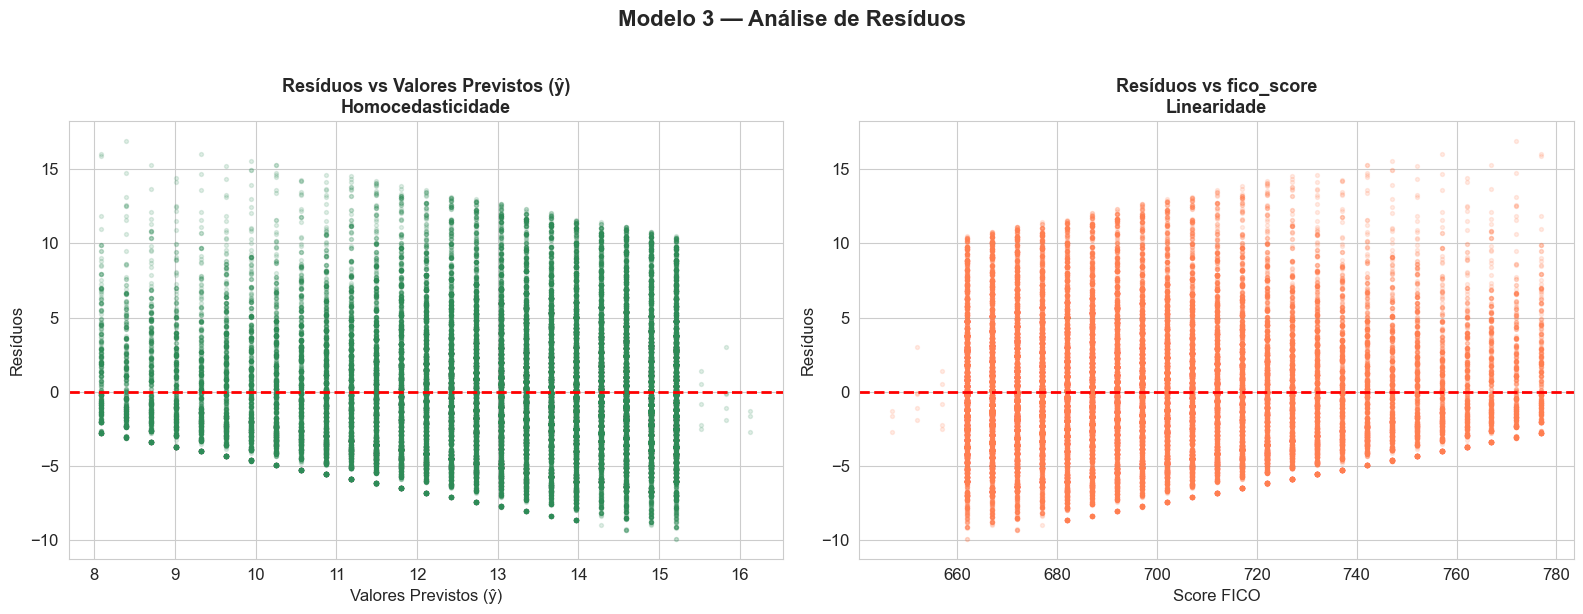

In [32]:
# =============================================================================
# 27. MODELO 3 — VALIDAÇÃO: LINEARIDADE E HOMOCEDASTICIDADE
# =============================================================================

residuos3 = y3_test - y3_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Resíduos vs ŷ → Homocedasticidade
axes[0].scatter(y3_pred, residuos3, alpha=0.15, s=8, color='seagreen')
axes[0].axhline(y=0, color='red', linewidth=2, linestyle='--')
axes[0].set_title('Resíduos vs Valores Previstos (ŷ)\nHomocedasticidade', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Valores Previstos (ŷ)')
axes[0].set_ylabel('Resíduos')

# Resíduos vs X → Linearidade
axes[1].scatter(X3_test, residuos3, alpha=0.15, s=8, color='coral')
axes[1].axhline(y=0, color='red', linewidth=2, linestyle='--')
axes[1].set_title('Resíduos vs fico_score\nLinearidade', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Score FICO')
axes[1].set_ylabel('Resíduos')

plt.suptitle('Modelo 3 — Análise de Resíduos', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 28 · Modelo 3: Validação das Premissas — Normalidade dos Resíduos (Q-Q Plot + Shapiro-Wilk)

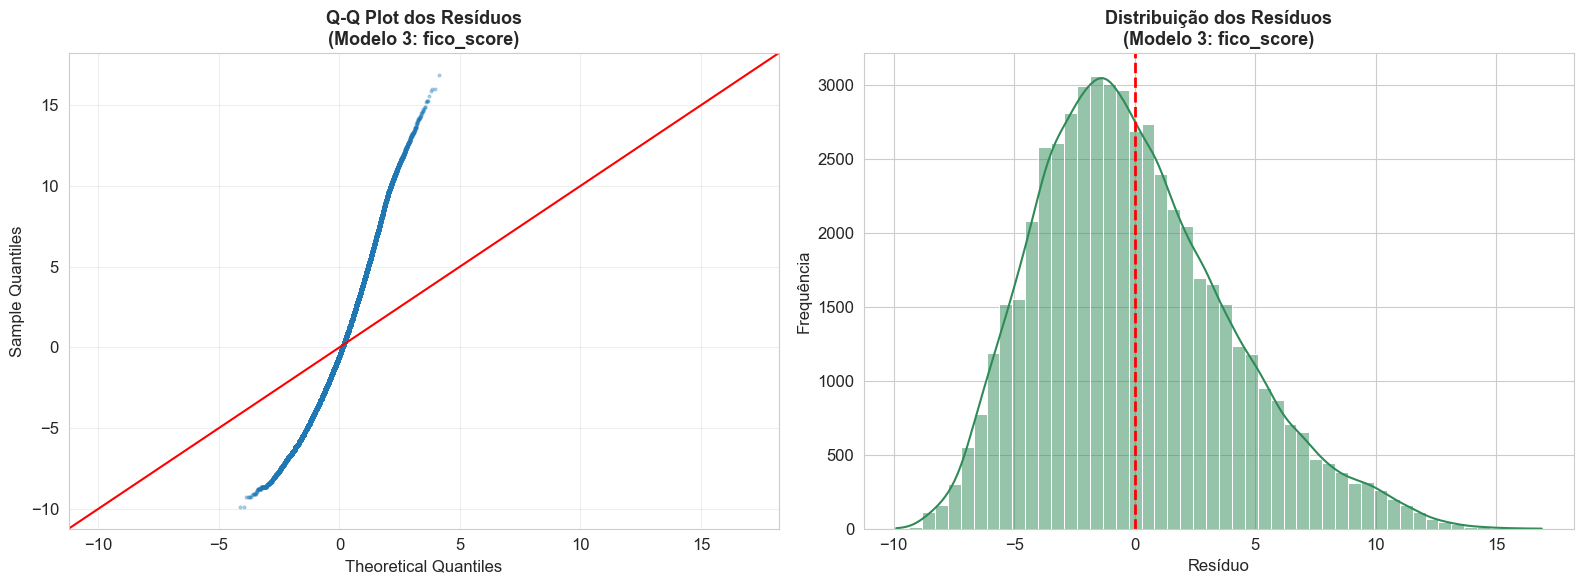

📊 Teste de Shapiro-Wilk (Modelo 3):
   Estatística W = 0.979025
   p-value       = 1.478296e-26
   ⚠️  H₀ rejeitada — desvio detectado (esperado com n grande).


In [33]:
# =============================================================================
# 28. MODELO 3 — VALIDAÇÃO: NORMALIDADE DOS RESÍDUOS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Q-Q Plot
qqplot(residuos3, line='45', ax=axes[0], markersize=2, alpha=0.3)
axes[0].set_title('Q-Q Plot dos Resíduos\n(Modelo 3: fico_score)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Histograma
sns.histplot(residuos3, kde=True, bins=50, color='seagreen', ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Distribuição dos Resíduos\n(Modelo 3: fico_score)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Resíduo')
axes[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# Shapiro-Wilk
amostra_residuos3 = np.random.choice(residuos3, size=min(5000, len(residuos3)), replace=False)
stat_sw3, p_sw3 = shapiro(amostra_residuos3)
print(f"📊 Teste de Shapiro-Wilk (Modelo 3):")
print(f"   Estatística W = {stat_sw3:.6f}")
print(f"   p-value       = {p_sw3:.6e}")
if p_sw3 > 0.05:
    print("   ✅ Não rejeitamos H₀: resíduos normais.")
else:
    print("   ⚠️  H₀ rejeitada — desvio detectado (esperado com n grande).")

### 29 · Modelo 3: Validação das Premissas — Independência (Durbin-Watson)

In [34]:
# =============================================================================
# 29. MODELO 3 — VALIDAÇÃO: INDEPENDÊNCIA (DURBIN-WATSON)
# =============================================================================

dw3 = durbin_watson(modelo3_ols.resid)
print(f"📊 Estatística de Durbin-Watson (Modelo 3): {dw3:.4f}")
if 1.5 < dw3 < 2.5:
    print("   ✅ Sem autocorrelação significativa.")
elif dw3 <= 1.5:
    print("   ⚠️  Possível autocorrelação positiva.")
else:
    print("   ⚠️  Possível autocorrelação negativa.")

📊 Estatística de Durbin-Watson (Modelo 3): 2.0009
   ✅ Sem autocorrelação significativa.


---
# 📊 COMPARAÇÃO E CONCLUSÕES

## 30 · Tabela Comparativa dos 3 Modelos

Reunimos todas as métricas lado a lado para comparar o desempenho de cada variável independente como preditora da taxa de juros.

In [35]:
# =============================================================================
# 30. TABELA COMPARATIVA DOS 3 MODELOS
# =============================================================================

# Extrair p-values dos coeficientes (β₁) de cada modelo OLS
p_m1 = modelo1_ols.pvalues[1]  # Índice 1 = coeficiente de X (índice 0 = constante)
p_m2 = modelo2_ols.pvalues[1]
p_m3 = modelo3_ols.pvalues[1]

# Criar tabela comparativa
comparacao = pd.DataFrame({
    'Modelo': ['Modelo 1', 'Modelo 2', 'Modelo 3'],
    'Variável (X)': ['annual_inc', 'dti', 'fico_score'],
    'R²': [r2_m1, r2_m2, r2_m3],
    'R² Ajustado': [modelo1_ols.rsquared_adj, modelo2_ols.rsquared_adj, modelo3_ols.rsquared_adj],
    'RMSE (%)': [rmse_m1, rmse_m2, rmse_m3],
    'MAE (%)': [mae_m1, mae_m2, mae_m3],
    'Coeficiente (β₁)': [beta1_m1, beta1_m2, beta1_m3],
    'p-value (β₁)': [p_m1, p_m2, p_m3],
    'Durbin-Watson': [dw1, dw2, dw3]
})

# Formatar para melhor visualização
print("=" * 90)
print("📊 TABELA COMPARATIVA — MODELOS DE REGRESSÃO LINEAR SIMPLES")
print("=" * 90)
comparacao_display = comparacao.copy()
comparacao_display['R²'] = comparacao_display['R²'].apply(lambda x: f"{x:.6f}")
comparacao_display['R² Ajustado'] = comparacao_display['R² Ajustado'].apply(lambda x: f"{x:.6f}")
comparacao_display['RMSE (%)'] = comparacao_display['RMSE (%)'].apply(lambda x: f"{x:.4f}")
comparacao_display['MAE (%)'] = comparacao_display['MAE (%)'].apply(lambda x: f"{x:.4f}")
comparacao_display['Coeficiente (β₁)'] = comparacao_display['Coeficiente (β₁)'].apply(lambda x: f"{x:.8f}")
comparacao_display['p-value (β₁)'] = comparacao_display['p-value (β₁)'].apply(lambda x: f"{x:.2e}")
comparacao_display['Durbin-Watson'] = comparacao_display['Durbin-Watson'].apply(lambda x: f"{x:.4f}")
comparacao_display

📊 TABELA COMPARATIVA — MODELOS DE REGRESSÃO LINEAR SIMPLES


Modelo Variável (X)        R² R² Ajustado RMSE (%) MAE (%)  \
0  Modelo 1   annual_inc  0.011064    0.011431   4.3261  3.4755   
1  Modelo 2          dti  0.025873    0.027493   4.2936  3.4483   
2  Modelo 3   fico_score  0.155121    0.156332   3.9986  3.1946   

  Coeficiente (β₁) p-value (β₁) Durbin-Watson  
0      -0.00001486     0.00e+00        2.0013  
1       0.08550598     0.00e+00        2.0027  
2      -0.06194709     0.00e+00        2.0009

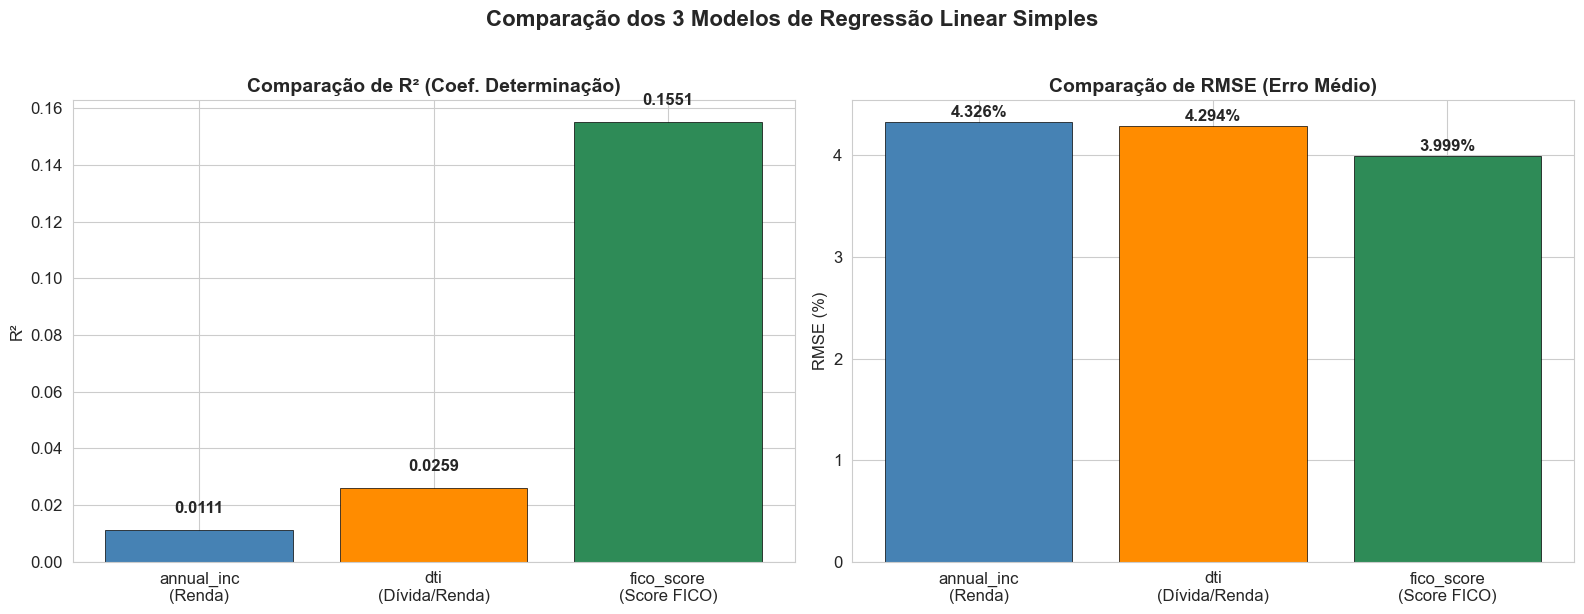


🏆 RANKING DOS MODELOS (por R², do melhor ao pior):
   1º lugar: Modelo 3 (fico_score) — R² = 0.15512067165347732
   2º lugar: Modelo 2 (dti) — R² = 0.025872782529409832
   3º lugar: Modelo 1 (annual_inc) — R² = 0.011064134804827264


In [36]:
# --- Gráficos Comparativos ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

nomes = ['annual_inc\n(Renda)', 'dti\n(Dívida/Renda)', 'fico_score\n(Score FICO)']
cores = ['steelblue', 'darkorange', 'seagreen']

# R²
r2_vals = [r2_m1, r2_m2, r2_m3]
bars1 = axes[0].bar(nomes, r2_vals, color=cores, edgecolor='black', linewidth=0.5)
axes[0].set_title('Comparação de R² (Coef. Determinação)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R²')
for bar, val in zip(bars1, r2_vals):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# RMSE
rmse_vals = [rmse_m1, rmse_m2, rmse_m3]
bars2 = axes[1].bar(nomes, rmse_vals, color=cores, edgecolor='black', linewidth=0.5)
axes[1].set_title('Comparação de RMSE (Erro Médio)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE (%)')
for bar, val in zip(bars2, rmse_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val:.3f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparação dos 3 Modelos de Regressão Linear Simples',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- Ranking ---
print("\n🏆 RANKING DOS MODELOS (por R², do melhor ao pior):")
ranking = comparacao.sort_values('R²', ascending=False)
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"   {i}º lugar: {row['Modelo']} ({row['Variável (X)']}) — R² = {row['R²']}")

---
## 31 · Bônus: Regressão Múltipla e Cálculo do VIF (Multicolinearidade)

Combinamos as **3 variáveis** em um único modelo de **Regressão Múltipla** para verificar se, juntas, elas explicam mais da variância de `int_rate`.

**Equação:**

$$\hat{y} = \beta_0 + \beta_1 \cdot \text{annual\_inc} + \beta_2 \cdot \text{dti} + \beta_3 \cdot \text{fico\_score}$$

**VIF (Variance Inflation Factor)** mede a **multicolinearidade** entre as variáveis independentes:

| VIF | Interpretação |
|---|---|
| 1 | Sem correlação entre as variáveis |
| 1–5 | Correlação moderada (aceitável) |
| 5–10 | Correlação alta (preocupante) |
| > 10 | Multicolinearidade severa (coeficientes instáveis) |

> Se o VIF for alto, os coeficientes individuais podem ser instáveis (mudam muito com pequenas alterações nos dados), mesmo que o modelo geral tenha bom R².

In [37]:
# =============================================================================
# 31. BÔNUS: REGRESSÃO MÚLTIPLA + VIF (MULTICOLINEARIDADE)
# =============================================================================

# --- Preparar dados com todas as 3 variáveis ---
X_multi = df[['annual_inc', 'dti', 'fico_score']].values
y_multi = df['int_rate'].values

X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split_manual(
    X_multi, y_multi, test_size=0.2, random_state=RANDOM_STATE
)

# --- OLS com statsmodels ---
X_multi_train_sm = sm.add_constant(X_multi_train)
X_multi_test_sm  = sm.add_constant(X_multi_test)

modelo_multi = sm.OLS(y_multi_train, X_multi_train_sm).fit()

print("=" * 70)
print("BÔNUS: REGRESSÃO MÚLTIPLA (annual_inc + dti + fico_score → int_rate)")
print("=" * 70)
print(modelo_multi.summary())

# --- Calcular VIF ---
# O VIF é calculado para cada variável independente.
# VIF_j = 1 / (1 - R²_j), onde R²_j é o R² da regressão de X_j contra as outras X's.
print("\n" + "=" * 50)
print("📊 VIF — Variance Inflation Factor")
print("=" * 50)

vif_data = pd.DataFrame()
vif_data['Variável'] = ['annual_inc', 'dti', 'fico_score']
vif_data['VIF'] = [
    variance_inflation_factor(X_multi_train_sm, i) 
    for i in range(1, X_multi_train_sm.shape[1])  # Começa em 1 para pular a constante
]

for _, row in vif_data.iterrows():
    status = '✅ OK' if row['VIF'] < 5 else '⚠️  Alta' if row['VIF'] < 10 else '🚨 Severa'
    print(f"   {row['Variável']:15s} → VIF = {row['VIF']:.4f}  ({status})")

# --- Métricas do modelo múltiplo (usando OLS) ---
y_multi_pred = modelo_multi.predict(X_multi_test_sm)

r2_multi   = r2_score_manual(y_multi_test, y_multi_pred)
rmse_multi = rmse_manual(y_multi_test, y_multi_pred)
mae_multi  = mae_manual(y_multi_test, y_multi_pred)

print(f"\n📊 Métricas da Regressão Múltipla (Teste):")
print(f"   R²:   {r2_multi:.6f}")
print(f"   RMSE: {rmse_multi:.4f}%")
print(f"   MAE:  {mae_multi:.4f}%")
print(f"\n   Comparação com melhor modelo simples (fico_score): R² = {r2_m3:.6f}")
print(f"   Ganho de R²: +{(r2_multi - r2_m3):.6f}")

BÔNUS: REGRESSÃO MÚLTIPLA (annual_inc + dti + fico_score → int_rate)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                 1.634e+04
Date:                Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:13:01   Log-Likelihood:            -5.9877e+05
No. Observations:              214589   AIC:                         1.198e+06
Df Residuals:                  214585   BIC:                         1.198e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

---
# 🎓 Como Explicar Isso Para o Seu Professor — Guia de Defesa

## Resumo Executivo das Métricas

### 1. R² (Coeficiente de Determinação)
> *"O R² nos diz qual percentual da variância da taxa de juros é explicado pela variável X."*

- Se o R² do Modelo 3 (fico_score) for, por exemplo, 0.42, você diz: **"O score FICO, sozinho, explica 42% da variação na taxa de juros."**
- Em Regressão Linear **Simples**, R² entre 0.10 e 0.50 é **informativo e esperado**, pois a taxa de juros depende de múltiplos fatores (risco, mercado, política da empresa).
- R² baixo **não significa que o modelo é inútil** — significa que a variável é **um** dos fatores, não o único.

### 2. RMSE (Root Mean Squared Error)
> *"O RMSE nos diz, em média, quantos pontos percentuais o modelo erra na previsão da taxa."*

- Se o RMSE for 3.5%, significa que o modelo **tipicamente erra em ±3.5 pontos percentuais**. Para uma taxa real de 15%, o modelo pode prever entre 11.5% e 18.5%.
- O RMSE é em **unidades da variável-alvo** (%), o que facilita a interpretação prática.
- O RMSE **penaliza mais erros grandes** (por causa da raiz do quadrado), então é mais conservador que o MAE.

### 3. MAE (Mean Absolute Error)
> *"O MAE é o erro médio absoluto — quanto o modelo erra, em média, sem penalizar erros grandes."*

- Se o MAE for 2.8%, o erro típico é de 2.8 pontos percentuais.
- Se RMSE >> MAE, significa que existem alguns erros muito grandes (outliers nos resíduos).

### 4. p-value dos Coeficientes
> *"O p-value nos diz se a relação entre X e Y é estatisticamente significativa ou se pode ser obra do acaso."*

- **p < 0.05**: Há evidência estatística de que a variável X influencia `int_rate`. O coeficiente é significativo.
- **p ≥ 0.05**: Não podemos afirmar com confiança que X influencia Y. O coeficiente pode ser zero na população.
- Na prática, se os p-values de todos os 3 modelos forem < 0.001 (muito pequenos), **todas as variáveis escolhidas são significativas**.

### 5. Coeficiente β₁ — Interpretação Prática
> *"O β₁ nos diz quanto a taxa de juros muda para cada unidade a mais na variável X."*

Exemplos de como falar na apresentação:
- **annual_inc:** *"Para cada dólar a mais de renda anual, a taxa de juros diminui em β₁ pontos percentuais. Como β₁ é muito pequeno (ex: -0.00001), faz mais sentido dizer: para cada $10.000 a mais, a taxa cai em ~0.1 pp."*
- **dti:** *"Para cada ponto percentual a mais no DTI, a taxa de juros aumenta em β₁ pp."*
- **fico_score:** *"Para cada ponto a mais no FICO score, a taxa de juros diminui em β₁ pp."*

### 6. Análise de Resíduos — Por que fizemos?
> *"As premissas do OLS (Mínimos Quadrados Ordinários) precisam ser satisfeitas para que os intervalos de confiança e p-values sejam válidos."*

| Premissa | O que verificamos | O que acontece se falhar |
|---|---|---|
| **Linearidade** | Scatter de resíduos vs X sem padrão curvilíneo | O modelo linear é inadequado; precisaríamos de transformações ou modelos não-lineares |
| **Homocedasticidade** | Scatter de resíduos vs ŷ sem formato de funil | Erros-padrão ficam enviesados → p-values não confiáveis |
| **Normalidade dos Resíduos** | Q-Q Plot + Shapiro-Wilk | Intervalos de confiança e testes de hipótese ficam imprecisos |
| **Independência** | Durbin-Watson ≈ 2 | Erros-padrão subestimados → testes de significância otimistas |

### 7. Por que a Rede Neural deu resultado (quase) igual?
> *"Um neurônio com ativação linear computa ŷ = Wx + b, que é algebricamente idêntico à equação da regressão linear ŷ = β₁x + β₀. A diferença é apenas o método de otimização: OLS encontra a solução analítica exata; a rede neural chega ao mesmo lugar via gradient descent iterativo."*

Isso demonstra que:
- Regressão linear é um **caso particular** de rede neural.
- Redes neurais ganham poder com **camadas adicionais** e **ativações não-lineares** (ReLU, Sigmoid), que não usamos aqui propositalmente.

### 8. Limitações e Honestidade Acadêmica
> *"R² baixo em regressão simples é esperado e aceitável. O objetivo não é construir o melhor modelo preditivo possível, mas sim demonstrar que cada variável, isoladamente, possui relação estatisticamente significativa com a taxa de juros, validando as premissas do OLS e interpretando os resultados com rigor."*

---

**Frase de encerramento sugerida:**

> *"Este trabalho demonstrou, com rigor estatístico, que renda anual, DTI e score FICO possuem relação significativa com a taxa de juros (todos com p < 0.05), sendo o FICO score o preditor mais forte. As premissas da regressão foram verificadas e discutidas, e a equivalência entre regressão linear e rede neural de um neurônio foi demonstrada matematicamente e empiricamente."*

---

<p align="center">
  <strong>📚 Projeto desenvolvido por Caio Thomas Silva Bandeira — CEUB 2026</strong>
</p>